In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from preprocessing import *
from clustering import *
from plotting import *
from sklearn.metrics import silhouette_score

from pandas.tools.plotting import table

%matplotlib inline

In [2]:
hdul=fits.open('objetos_con_todo_vrad_ppm_etc.fits-plus')
t1 = Table(hdul[1].data,meta=hdul[1].header)
t2 = Table(hdul[2].data,meta=hdul[2].header)
t3 = Table(hdul[3].data,meta=hdul[3].header)
df_base = t1.to_pandas()
df_hsoy = t2.to_pandas()
df_simbad= t3.to_pandas()

#print(df_base.shape)
#print(df_hsoy.shape)
#print(df_simbad.shape)

#se corrigen errores de formato en el dataset
df_hsoy = df_hsoy.rename(columns={'Q2-Q2promedio;;;;;;;;;;;;;;;;;;;': 'Q2-Q2promedio'})
df_hsoy["Q2-Q2promedio"] = df_hsoy["Q2-Q2promedio"].apply(clean)

#Se corrige la magnitud [por el momento se reemplaza por Lbol]
#df_hsoy["Abs Mag"]= df_hsoy["Mean mag"]+5-np.log(df_hsoy["D (pc)"])

#Se agregan los valores absolutos de Q1 y Q2
df_hsoy["Abs Q1"]= np.abs(df_hsoy["Q1-Q1promedio"])
df_hsoy["Abs Q2"]= np.abs(df_hsoy["Q2-Q2promedio"])

#Se obtiene el log10 de la luminosidad en unidades solares 
df_hsoy["logLbol"]= np.log10(df_hsoy["Lbol"])

#Se calcula la magnitud de la proper motion
df_hsoy["pm"]= np.sqrt(df_hsoy["pmra"]*df_hsoy["pmra"] + df_hsoy["pmde"]*df_hsoy["pmde"])

#Pre seleccion de las features a usarpara el analisis
#features_hsoy = ["logLbol","M1","Rad1","logg","D (pc)","Teff","Meta.","Abs Q1","Abs Q2","C1","C2","pm","Av"]
features_hsoy = ["logLbol","M1","eM1","Rad1","eRad1","M2","eM2","Rad2","eRad2","logg","e_logg","D (pc)","Teff","e_Teff","Meta.","Av","C1","C2","pm"]


In [3]:
print(df_hsoy.shape[0])

11317


In [4]:
# Estrellas selecionadas
xstd,xstd_info,x,x_info = stars_selection(df_hsoy,features_hsoy)
xstd.shape

(529, 19)

In [5]:
print(x["eRad1"].describe())
print(x["eRad2"].describe())

count       529.000000
mean       1124.966064
std       24406.318359
min           0.000000
25%           0.039464
50%           0.247651
75%           2.643044
max      561251.250000
Name: eRad1, dtype: float64
count       529.000000
mean       1142.778076
std       24782.927734
min           0.002533
25%           0.103103
50%           0.336997
75%           3.677686
max      569915.687500
Name: eRad2, dtype: float64


In [6]:
print(x["eM1"].describe())
print(x["eM2"].describe())

count    5.290000e+02
mean     4.647912e+04
std      8.973757e+05
min      7.933512e-09
25%      2.459853e-03
50%      1.674101e-01
75%      6.110038e+00
max      2.049483e+07
Name: eM1, dtype: float64
count    5.290000e+02
mean     4.827685e+04
std      9.252048e+05
min      9.235816e-09
25%      2.484940e-03
50%      1.800572e-01
75%      6.161719e+00
max      2.111595e+07
Name: eM2, dtype: float64


Matriz de correlaciones con toda la data


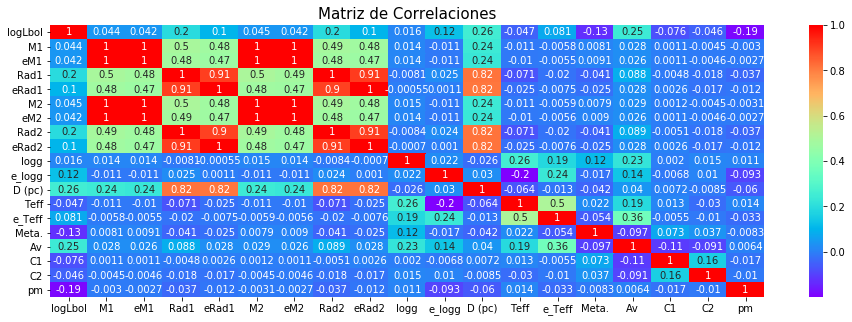

In [7]:
print("Matriz de correlaciones con toda la data")
plotting_correlation_matrix(df_hsoy,features_hsoy,c="rainbow")

Matriz de correlaciones con la data seleccionada


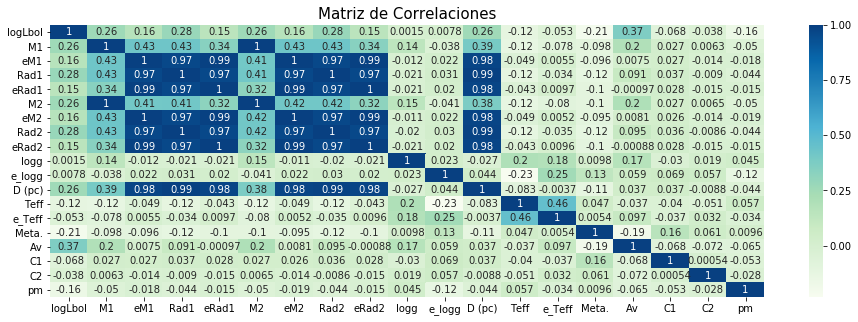

In [8]:
print("Matriz de correlaciones con la data seleccionada")
plotting_correlation_matrix(x,features_hsoy,c="GnBu")

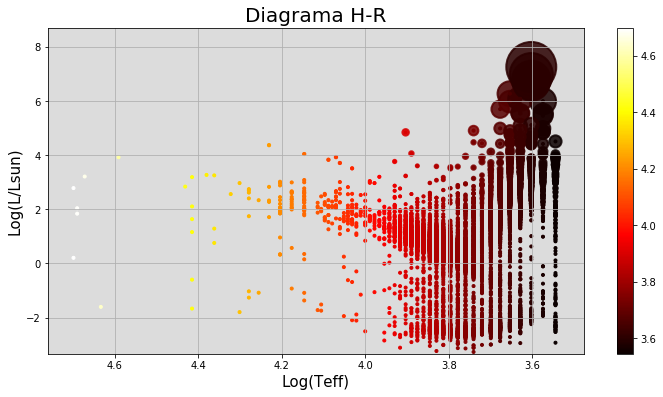

In [9]:
plot_hr_diagram(df_hsoy,size_feature="Rad1",semilogx=True,s=(12,6))

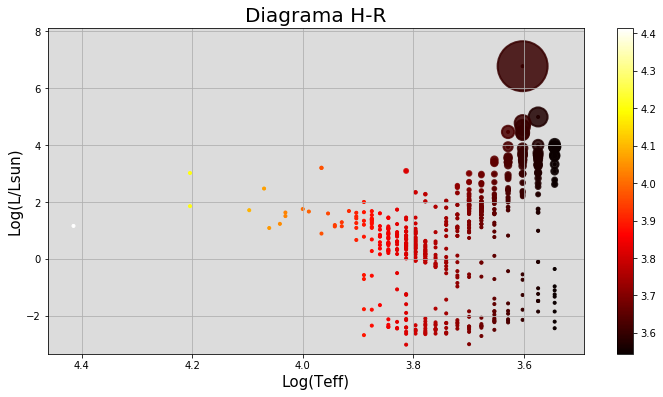

In [10]:
plot_hr_diagram(x,size_feature="Rad1",semilogx=True,s=(12,6))

# Proceso para encontrar grupos en la data seleccionada

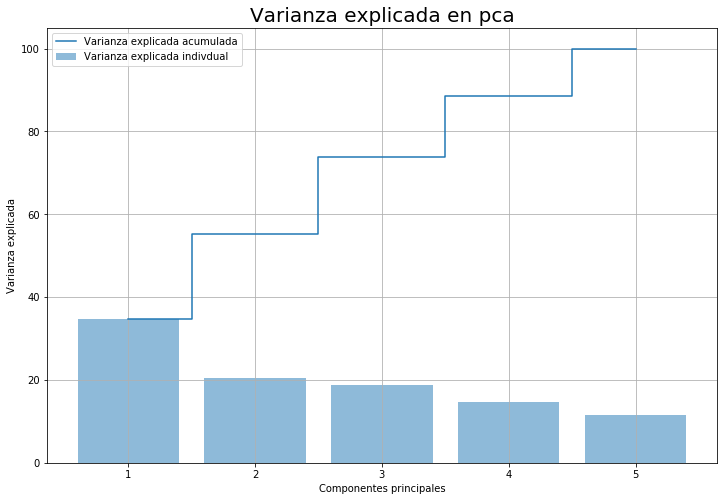

In [11]:
#test_features= ["logLbol","Teff","D (pc)","Rad2","M2","pm"]
#test_features= ["Rad2","M2","pm","Teff","logLbol"]
test_features= ["Rad1","M1","pm","Teff","logLbol"]
plot_pca_explained_variance(xstd[test_features])

In [12]:
xpca,components= apply_pca(xstd[test_features],n=4)
info= pc_info(components,test_features,print_w= False,print_p=False,r="r1")
info

PC1        PC2        PC3        PC4
Rad1     26.991622  15.870062   7.842266  12.580433
M1       26.650126  15.695432   6.404888  19.769623
pm        9.540331  47.249328  14.875501  21.396367
Teff     13.123177  10.037081  59.854121   0.690126
logLbol  23.694744  11.148097  11.023224  45.563451

2


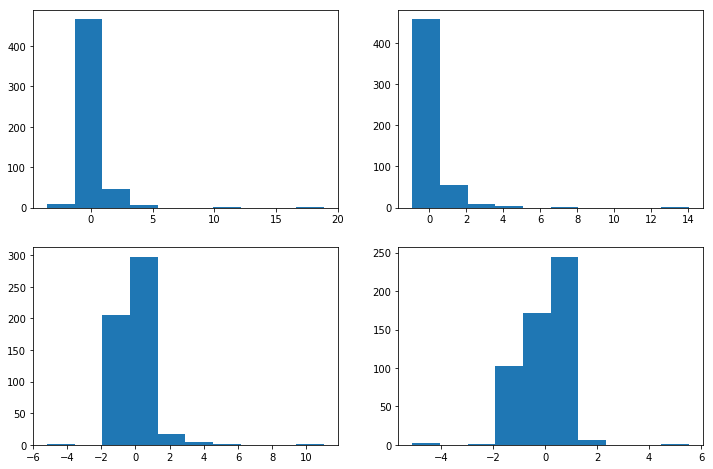

In [13]:
fig = plt.figure(figsize=(12,8))
l= xpca.shape[1]
m= int(np.ceil(l/2))
print(m)
gs = gridspec.GridSpec(m, 2)

for i in range(m):
    if 2*i <= l-1:
        ax= fig.add_subplot(gs[i, 0])
        ax.hist(xpca[:,2*i])
    if 2*i+1 <=l-1:
        ax= fig.add_subplot(gs[i, 1])
        ax.hist(xpca[:,2*i+1])

2.31276506997
34
[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


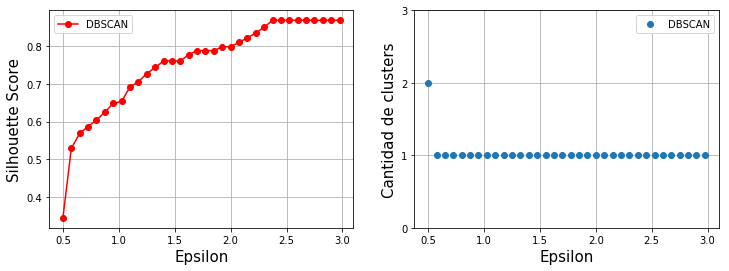

In [79]:
c= get_epsilon(xpca,0.025)
print(c)
n_epsilons = np.arange(0.5,3,0.075)
#rad_dbscan_analisys(xstd,n_epsilons,p=0.025)

s= []
nc= []
for i in n_epsilons:
    dbl= apply_dbscan(xpca,i,0.025,report=False)
    s.append(silhouette_score(xpca,dbl,metric='euclidean'))
    nc.append(np.max(dbl)+1)

print(len(nc))
print(nc)
    

fig = plt.figure(figsize=(12,4))   
gs = gridspec.GridSpec(1, 2)

ax= fig.add_subplot(gs[0, 0])
ax.plot(n_epsilons,s,"o-",c="r",label="DBSCAN")
ax.legend(loc="best")
ax.set_xlabel("Epsilon",fontsize=15)
ax.set_ylabel("Silhouette Score",fontsize=15)
ax.grid()
    
ax= fig.add_subplot(gs[0, 1])
ax.plot(n_epsilons,nc,"o",linewidth=200,label="DBSCAN")
#ax.bar(n_epsilons,nc,width=0.04,align="edge",label="DBSCAN")
ax.legend(loc="best")
ax.set_xlabel("Epsilon",fontsize=15)
ax.set_ylabel("Cantidad de clusters",fontsize=15)
ax.set_yticks([0,1,2,3])
ax.grid()
    


In [15]:
#Se aplica DBSCAN a modo de tratamiento de Outliers
c= get_epsilon(xpca,0.025)
n0= get_k_clusters(xpca)

dbl= apply_dbscan(xpca,2.68887,0.025)
#dbl= apply_dbscan(xpca,c,0.025)
db_cpca,db_cx,db_npca,db_nx= get_clusters(xpca,x,dbl)

#Se aplica K-MEANS sobre elcluster unico encontrado por DBSCAN
n= get_k_clusters(db_cpca[0])
kl,c= apply_kmeans(db_cpca[0],k=n[0])
#aggl= apply_agg(db_cpca[0],k=5)

k_cpca,k_cx= get_clusters(db_cpca[0],db_cx[0],kl,r="r2")

###################################
#####      DBSCAN report      #####
###################################
Min samples=  13.0
Epsilon(rad)=  2.68887
Number of clusters=  1
Noise=  4  elements
Silhouette score=  0.869378541925
###################################
###################################
#####      KMEANS report      #####
###################################
Number of clusters=  6
Silhouette score=  0.441356765542
###################################


[2 3 4 5 6 7 8 9]
[0.33716647569238817, 0.39255504613694808, 0.41699871719912368, 0.44007454417061515, 0.44135676554161452, 0.4075252451220977, 0.40146767031231018, 0.37674034579526633]


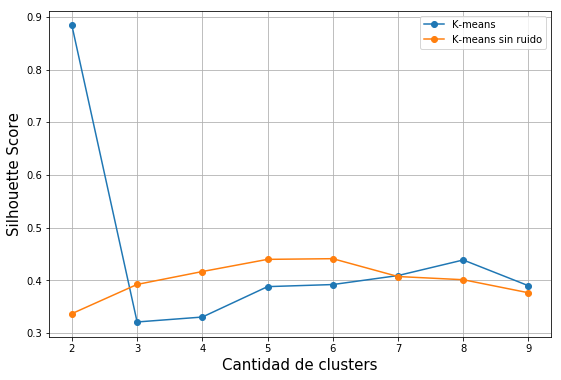

In [16]:
scores0= n0[1]
scores1= n[1]
axis_x= np.arange(2,2+len(scores1))
print(axis_x)
print(scores1)
fig=plt.figure(figsize=(9,6))
ax= fig.add_subplot(111)
ax.plot(axis_x,scores0,"o-",label="K-means")
ax.plot(axis_x,scores1,"o-",label="K-means sin ruido")
ax.legend(loc="best")
ax.set_xlabel("Cantidad de clusters",fontsize=15)
ax.set_ylabel("Silhouette Score",fontsize=15)
ax.grid()


In [17]:
# Se quita el cluster menos denso y se vuelve a aplicar k-Means
index,pca_data,data= drop_cluster(k_cpca,k_cx)

n= get_k_clusters(pca_data)
kl2,c2= apply_kmeans(pca_data,k=n[0])

#aggl2= apply_agg(pca_data,k=4)
k_cpca2,k_cx2= get_clusters(pca_data,data,kl2,r="r2")

###################################
#####      KMEANS report      #####
###################################
Number of clusters=  5
Silhouette score=  0.441455082219
###################################


In [18]:
# Se repite nuevamente el paso anterior
index2,pca_data2,data2= drop_cluster(k_cpca2,k_cx2)
n= get_k_clusters(pca_data2)
kl3,c3= apply_kmeans(pca_data2,k=n[0])
#aggl3= apply_agg(pca_data2,k=4)
k_cpca3,k_cx3= get_clusters(pca_data2,data2,kl3,r="r2")


#Se junta el resultado obtenido en este paso junto con los dos clusters quitados en los pasos anteriores.
all_pca1= append_clusters(k_cpca2[index2],k_cpca3)
all_data1= append_clusters(k_cx2[index2],k_cx3)

all_pca_data= append_clusters(k_cpca[index],all_pca1)
all_data= append_clusters(k_cx[index],all_data1)


# Se mide el score de todo el proceso
sdata= []
slabels= []
for i in range(len(all_pca_data)):
    for j in range(all_pca_data[i].shape[0]):
        sdata.append(all_pca_data[i][j])
        slabels.append(i+1)

slabels= np.array(slabels)
print("\nSilhouette Score Total= ",
      silhouette_score(sdata,slabels,metric='euclidean'))

k_cpca3,k_cx3= get_clusters(pca_data2,data2,kl3,r="r2")


###################################
#####      KMEANS report      #####
###################################
Number of clusters=  4
Silhouette score=  0.444607855203
###################################

Silhouette Score Total=  0.440397921788


# Resultados

In [19]:
pc,components= apply_pca(xstd[features_hsoy],n=len(features_hsoy))
per= pc_info(components,features_hsoy,print_w=False,print_p=False,r="r1")
per

PC1        PC2        PC3        PC4        PC5        PC6  \
logLbol   3.211872  11.017269   0.325442   0.303527  11.421305   3.683290   
M1        6.062558  14.395312   0.048672   2.185948  10.912931   0.607163   
eM1      11.352213   3.167197   0.958756   0.473321   0.563834   0.334797   
Rad1     11.382463   1.522122   0.589120   0.052844   1.620571   0.153081   
eRad1    11.189291   4.639848   0.963331   0.895890   0.778691   0.207451   
M2        5.912318  14.608527   0.039616   2.113848  10.927872   0.602516   
eM2      11.357261   3.085775   0.957042   0.453473   0.631536   0.340601   
Rad2     11.379968   1.435504   0.607780   0.039910   1.632532   0.138837   
eRad2    11.189844   4.636844   0.961688   0.895229   0.777847   0.208229   
logg      0.006202   5.103814  19.437683   2.259980   6.062965   3.761352   
e_logg    0.284043   1.072055   1.708165  24.140060   6.704093   5.078038   
D (pc)   11.344061   2.721426   0.140957   0.162199   1.506736   0.076702   
Teff      1.238813   4.710282  26.141864   7.747175   4.247736   7.204134   
e_Teff    0.315324   3.192224  27.705236   8.520738   2.887396   0.958375   
Meta.     1.639467   6.177616   1.805462  13.706935  10.543978   6.162965   
Av        1.033894  12.011714   9.186330   1.175547   9.941256   3.977471   
C1        0.370992   2.224090   5.556553  12.618519   7.322467  24.055354   
C2        0.169992   0.966593   1.327201   9.269813   3.553369  33.513336   
pm        0.559422   3.311787   1.539103  12.985044   7.962883   8.936308   

               PC7        PC8        PC9       PC10       PC11       PC12  \
logLbol   4.760672   7.796452   4.739469  12.831078  28.154899   1.529650   
M1        1.424619   6.912414   4.433066   2.268180   0.285224   1.101268   
eM1       0.258018   0.657100   0.362483   0.631936   1.519777   0.631835   
Rad1      0.385670   1.706891   1.239784   0.562555   0.156990   0.664218   
eRad1     0.392733   0.530346   0.845707   1.196129   1.658381   0.207122   
M2        1.463865   6.842432   4.490760   2.168597   0.338757   1.018907   
eM2       0.248791   0.713776   0.335332   0.603726   1.513025   0.649172   
Rad2      0.395624   1.765452   1.290401   0.606116   0.225711   0.742681   
eRad2     0.394632   0.530321   0.849002   1.197626   1.660185   0.210002   
logg      8.808985   8.613163  15.082320  20.072062   9.316156   3.119197   
e_logg   15.315456   7.408624   5.286440   1.542644   6.579765  21.324315   
D (pc)    0.081891   0.929273   0.742781   0.217986   1.480902   0.144207   
Teff     11.802395   0.035941   1.143454   6.809485   2.074426  28.306980   
e_Teff    1.193255   5.335444  10.969898   5.721283   0.937163  27.601837   
Meta.     2.416472   0.349757  20.002164  18.234113   3.495609   4.940697   
Av        7.400420  10.863677   2.536410   6.358116  28.910833   3.820908   
C1        3.700397  17.486937  13.225535   4.516873   2.228040   0.779223   
C2       14.345844  12.911114   3.200851   2.944278   2.734274   2.584242   
pm       25.210262   8.610885   9.224144  11.517217   6.729884   0.623541   

              PC13       PC14       PC15       PC16       PC17       PC18  \
logLbol   4.882876   0.853243   0.159427   0.058056   0.019246   0.001681   
M1        0.120043   1.240473   1.444963  34.190530  10.054254   0.476756   
eM1      11.170008   1.744554  19.285698   2.350349   1.490155  31.689317   
Rad1     16.971340  15.281457   2.804167   9.270268  37.992716   0.455230   
eRad1    10.592048   6.671107  19.364327   3.377806   0.800272  18.549639   
M2        0.268262   1.412964   6.068086  33.297593   9.790797   0.516803   
eM2      11.176895   2.202532  20.774541   4.125896   0.586554  30.499704   
Rad2     17.251166  17.081520   3.312616   8.975369  36.704812   0.332185   
eRad2    10.565972   6.820041  19.164642   3.012979   1.409354  17.315157   
logg      0.169171   0.189937   0.310133   0.025002   0.013712   0.004565   
e_logg    0.004649   0.843524   0.265130   0.053215   0.038276   0.001530   
D (pc)   

rad vs D - Av vs D - logg vs Teff - Abs Q2 vs pm
pm vs Teff - Abs Q1 vs Teff - Abs Q1 vs Meta - Meta vs Lbol 
M2 vs Logg - Lbol vs Av - Rad vs M

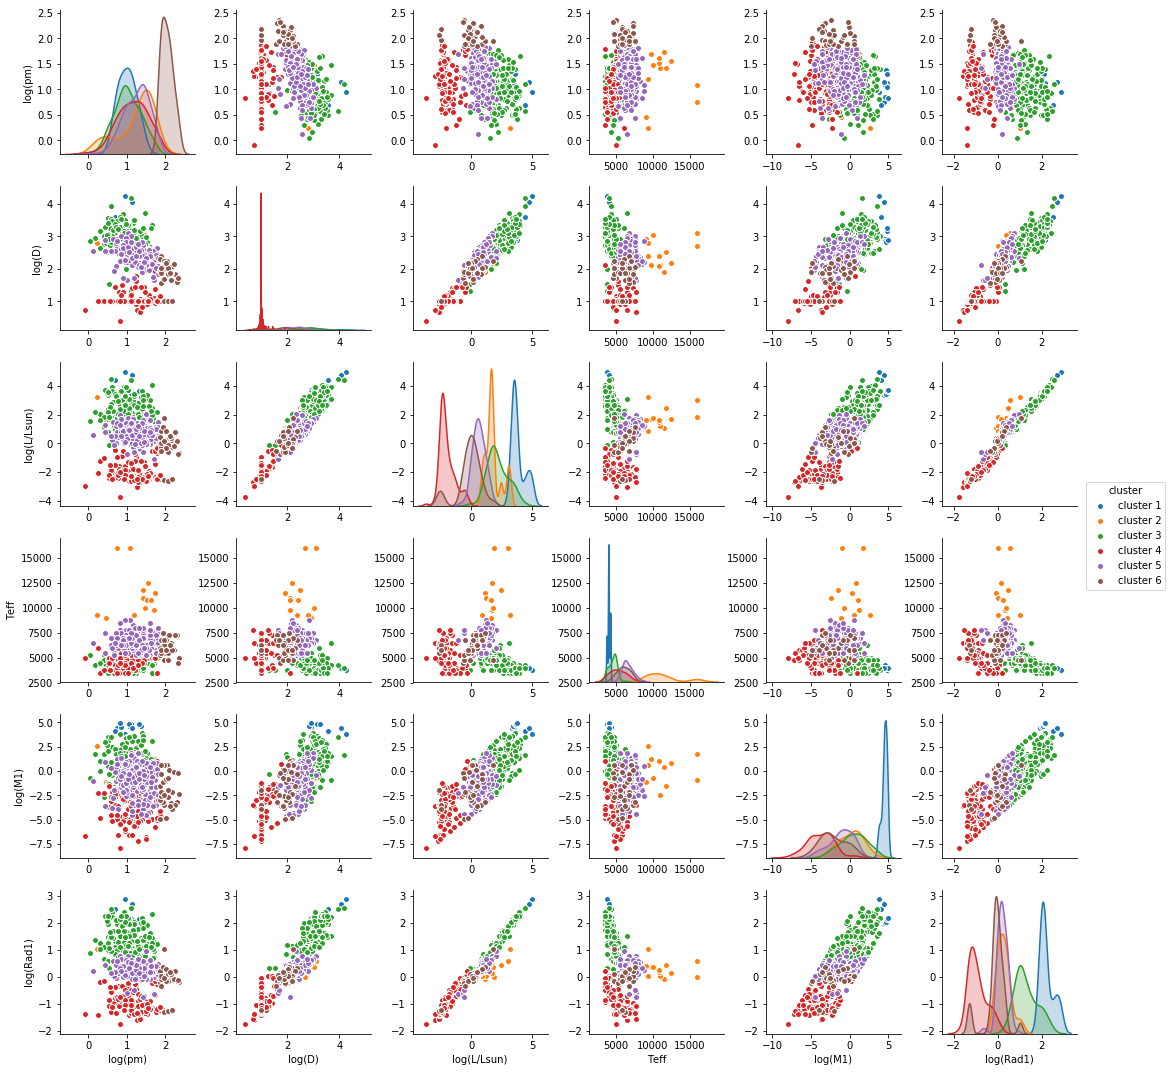

In [20]:
test_features= ["pm","D (pc)","logLbol","Teff","M1","Rad1"]
pairplot(all_data,test_features)

In [21]:
def plot_compare_features(df,data,feature_x,feature_y,s=(16,16),semilogx=False,semilogy=False,invert_x=False,invert_y=False):

    fig = plt.figure(figsize=s)
    #m= int(np.ceil(len(data)/2))
    m= int(np.ceil(len(features/2)))
    gs = gridspec.GridSpec(m, 2)


    for i in range(m):
        xdf, ydf= apply_log10(df[feature_x],df[feature_y],semilogx,semilogy)
        if 2*i <= len(data)-1:
            mfx_true= np.round(data[2*i][feature_x].mean(),3)
            mfy_true= np.round(data[2*i][feature_y].mean(),3)
            xdata_par, ydata_par= apply_log10(data[2*i][feature_x],data[2*i][feature_y],semilogx,semilogy)
            ax= fig.add_subplot(gs[i, 0])

            mfx= np.round(xdata_par.mean(),3)
            mfy= np.round(ydata_par.mean(),3)
            l= "Average "+feature_x+"= "+str(mfx_true)+"\nAverage "+feature_y+"= "+str(mfy_true)
            ax.scatter(xdf,ydf,c="gray",label="All data", alpha= 0.15)
            ax.scatter(xdata_par,ydata_par,c= "C"+str(2*i),label=l)
            ax.plot(mfx,mfy,c="k",marker= "*")
            ax.legend()
            ax.set_title("Cluster " + str(2*i+1))
            ax.set_xlabel(feature_x)
            ax.set_ylabel(feature_y)
            if invert_x == True:
                ax.invert_xaxis()
            if invert_y == True:
                ax.invert_yaxis()
            ax.grid()

        if 2*i + 1 <= len(data)-1:

            ax= fig.add_subplot(gs[i, 1])
            mfx_true= np.round(data[2*i+1][feature_x].mean(),3)
            mfy_true= np.round(data[2*i+1][feature_y].mean(),3)
            xdata_impar, ydata_impar= apply_log10(data[2*i+1][feature_x],data[2*i+1][feature_y],semilogx,semilogy)

            mfx= np.round(xdata_impar.mean(),3)
            mfy= np.round(ydata_impar.mean(),3)
            l= "Average "+feature_x+"= "+str(mfx_true)+"\nAverage "+feature_y+"= "+str(mfy_true)
            ax.scatter(xdf,ydf,c="gray",label="All data", alpha= 0.15)
            ax.scatter(xdata_impar,ydata_impar,c= "C"+str(2*i+1),label= l)
            ax.plot(mfx,mfy,c="k",marker= "*")
            ax.legend()
            ax.set_title("Cluster " + str(2*i+2))
            ax.set_xlabel(feature_x)
            ax.set_ylabel(feature_y)
            if invert_x == True:
                ax.invert_xaxis()
            if invert_y == True:
                ax.invert_yaxis()
            ax.grid()

    plt.tight_layout()

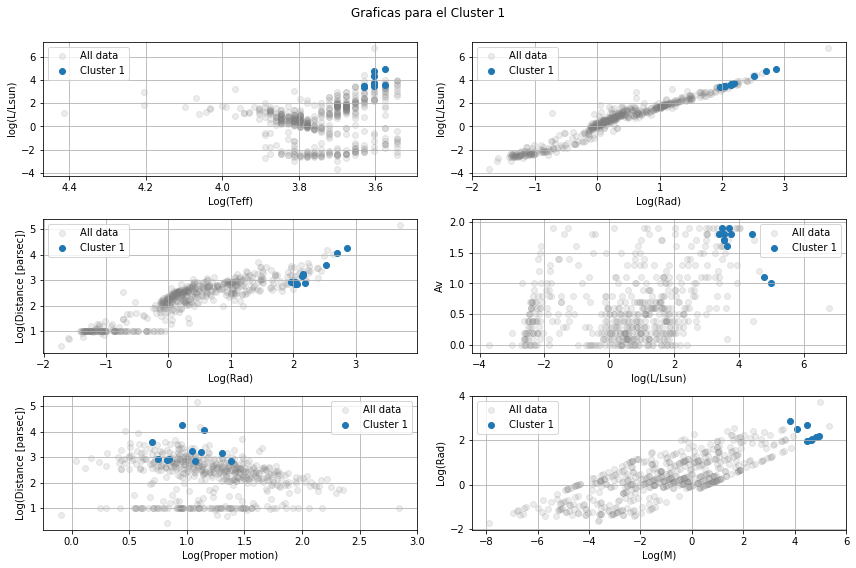

In [22]:
def names(x,flag):
    if x == "logLbol":
        y= "log(L/Lsun)"
    elif x=="logg":
        y= "Log(g)"
    elif x == "Teff" and flag==True:
        y= "Log(Teff)"
    elif x== "Rad2" and flag==True:
        y= "Log(Rad)"
    elif x == "D (pc)" and flag==True:
        y= "Log(Distance [parsec])"
    elif x == "pm" and flag==True:
        y= "Log(Proper motion)"
    elif x =="M2" and flag==True:
        y= "Log(M)"
    else:
        y = x
    return y



combined_features=[("Teff","logLbol"),("Rad2","logLbol"),("Rad2","D (pc)"),("logLbol","Av"),("pm","D (pc)"),("M2","Rad2")]


def plot_compare_features(df,cluster,combined_features,s,c,title):
    fig = plt.figure(figsize=s)
    m= int(np.ceil(len(combined_features)/2))
    gs = gridspec.GridSpec(m, 2)
    #plt.suptitle("asdf")
    for i in range(m):
        if 2*i <= len(combined_features)-1:
            flagx= False
            flagy= False
            fx= combined_features[2*i][0]
            fy= combined_features[2*i][1]
            ax= fig.add_subplot(gs[i, 0])
            if fx=="D (pc)" or fx == "Rad2" or fx=="pm" or fx=="Teff" or fx == "M2":
                all_x= np.log10(df[fx])
                cx= np.log10(cluster[fx])
                flagx= True
            else:
                all_x =df[fx]
                cx= cluster[fx]
            if fy=="D (pc)" or fy== "Rad2" or fy=="pm" or fy == "Teff" or fy=="M2":
                all_y= np.log10(df[fy])
                cy= np.log10(cluster[fy])
                flagy= True
            else:
                all_y =df[fy]
                cy= cluster[fy]
            
            ax.scatter(all_x,all_y,c="gray",label="All data", alpha= 0.15)
            ax.scatter(cx,cy,c=c,label=title)
            x_title= names(fx,flagx)
            y_title= names(fy,flagy)
            ax.set_xlabel(x_title,fontsize=10)
            ax.set_ylabel(y_title,fontsize=10)
            ax.grid()
            ax.legend()
            if fx == "Teff" and fy == "logLbol":
                ax.invert_xaxis()
                
        if 2*i+1 <= len(combined_features)-1:
            flagx= False
            flagy= False
            ax= fig.add_subplot(gs[i, 1])
            fx= combined_features[2*i+1][0]
            fy= combined_features[2*i+1][1]
            if fx=="D (pc)" or fx == "Rad2" or fx=="pm" or fx=="Teff" or fx=="M1" or fx=="M2":
                all_x= np.log10(df[fx])
                cx= np.log10(cluster[fx])
                flagx= True
            else:
                all_x =df[fx]
                cx= cluster[fx]
            if fy=="D (pc)" or fy== "Rad2" or fy=="pm" or fy == "Teff" or fy =="M1" or fy =="M2":
                all_y= np.log10(df[fy])
                cy= np.log10(cluster[fy])
                flagy= True
            else:
                all_y =df[fy]
                cy= cluster[fy]
                
            ax.scatter(all_x,all_y,c="gray",label="All data", alpha= 0.15)
            ax.scatter(cx,cy,c=c,label=title)
            x_title= names(fx,flagx)
            y_title= names(fy,flagy)
            ax.set_xlabel(x_title,fontsize=10)
            ax.set_ylabel(y_title,fontsize=10)
            ax.grid()
            ax.legend()
            if fx == "Teff" and fy == "logLbol":
                ax.invert_xaxis()
    plt.suptitle("Graficas para el "+title,fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)

k=0
plot_compare_features(x,all_data[k],combined_features,s=(12,8),c="C"+str(k),title="Cluster "+str(k+1))

In [23]:
suma= 0
for i in range(len(all_data)):
    print("Elementos pertenecientes a: ",i+1, "son ", all_data[i].shape[0])
    suma = suma+all_data[i].shape[0]
print(suma)

Elementos pertenecientes a:  1 son  11
Elementos pertenecientes a:  2 son  13
Elementos pertenecientes a:  3 son  181
Elementos pertenecientes a:  4 son  117
Elementos pertenecientes a:  5 son  173
Elementos pertenecientes a:  6 son  30
525


In [24]:
table_df= pd.DataFrame()
for i in all_data:
    a= i.describe()
    a= a.iloc[1:2]
    table_df= pd.concat([a,table_df],ignore_index=True)

table_df= table_df.iloc[::-1]
for i in range(len(all_data)):
    table_df= table_df.rename({i: "Promedio ""cluster"+str(len(all_data)-i)}, axis="index")
table_df

logLbol            M1            eM1        Rad1  \
Promedio cluster1  3.882822  42811.347656  144058.437500  227.148209   
Promedio cluster2  1.817466     39.259342      35.359337    2.520962   
Promedio cluster3  2.189235    302.430328     592.143860   40.661606   
Promedio cluster4 -1.999366      0.168491       0.253638    0.210983   
Promedio cluster5  0.647696      2.700975       3.544643    1.924256   
Promedio cluster6 -0.128074      0.542906       0.605910    1.319771   

                         eRad1            M2            eM2        Rad2  \
Promedio cluster1  1577.428101  46956.339844  154645.171875  234.329895   
Promedio cluster2     0.568673     77.083885      74.616241    3.123772   
Promedio cluster3    76.778038    337.388947     686.378479   42.117485   
Promedio cluster4     0.078758      0.190119       0.286213    0.217531   
Promedio cluster5     0.620631      2.869373       3.900903    1.876090   
Promedio cluster6     0.076718      0.527822       0.606451    1.308489   

                         eRad2      logg    e_logg       D (pc)          Teff  \
Promedio cluster1  1618.426514  4.500000  0.377040  3731.937256   4022.727295   
Promedio cluster2     0.906933  4.076923  0.285724   442.244263  11346.154297   
Promedio cluster3    77.711159  2.386740  0.513745  1139.246094   4563.536133   
Promedio cluster4     0.097574  2.564103  0.475693    15.779093   5269.230957   
Promedio cluster5     0.713109  3.000000  0.428822   311.305786   6624.277344   
Promedio cluster6     0.182433  2.533333  0.430579    93.519531   6041.666504   

                       e_Teff     Meta.        Av        C1        C2  \
Promedio cluster1  131.551178 -1.436364  1.645455  0.983309  0.989000   
Promedio cluster2  424.170380 -1.500000  1.292308  0.952231  0.990131   
Promedio cluster3  201.408112 -0.566851  0.794475  0.962533  0.989287   
Promedio cluster4  212.595871 -0.259829  0.555555  0.974609  0.991063   
Promedio cluster5  219.108047 -0.178035  0.419653  0.971138  0.984869   
Promedio cluster6  201.538879 -0.473333  0.526667  0.961930  0.981263   

                           pm  
Promedio cluster1   11.624523  
Promedio cluster2   25.730175  
Promedio cluster3   14.274696  
Promedio cluster4   20.833193  
Promedio cluster5   23.342367  
Promedio cluster6  117.811783

* Cluster1 [Super gigantes] [Grupo bastante pequeño ~ 11 elementos] 
    * Luminosidad,masa,radio,distancia y gravedad promedio más altos.
    * Temperatura efectiva más baja.
    * Magnitud en la metalicidad alta.
    * pm más bajo.
    * Av más alto.
    
* Cluster4 [Sub gigantes/Gigantes][Grupo más grande ~ 180 elementos]
    * Luminosidad, radio, masa altas solo superado por cluster1.
    * Magnitud promedio de la gravedad es la más baja. *¿Esto es normal?
    * Temperatura efectiva baja.
    * Magnitud en la metalicidad baja.
    * pm bajo.
    
* Cluster2 [Secuencia principal][Grupo pequeño ~ 13 elementos]
    * Luminosidad más alta desúes de gigantes y super-gigantes.
    * Magnituda promedio de la metalicidad es la más alta.
    * Temperatura efectiva más alta.
    * Masa,radio y distancia altos, solo superado por gigantes/super gigantes.
    * Magnitud promedio de la gravedad alta , solo superada por grupo de las super gigantes.
    * pm dentro de los valores medios.
    * Av alto.
    
* Cluster3 [Secuencia principal] [Grupo grande ~ 178 elementos]
     * Luminosidad baja.
     * Masa, radio, bajos.
     * Distancia y temperatura efectiva altas.
     * Magnitud promedio de la metalicidad es la más baja.
     * pm dentro de los valores medios
     * Av bajo.
     
* Cluster5 [Secuencia principal] [Grupo pequeño ~ 28 elementos]
     * Luminosidad muy baja.
     * Radio, Masa,bajos.
     * gravedad dentro de los valores medios, pero más alto que en el grupo de las gigantes.
     * Valor promedio de la distancia es de los más bajos.
     * Pm es el más alto de todos.
     * Metalicidad y Av bajos.
     
* Cluster6 [Secuencia princiapal (??) ] [Grupo grande ~ 115 elementos]
     * Luminosidad, radio, masa y distancia promedio mas bajos.
     * Magnitud de la log gravedad baja pero más alta que en clusters con estrellas mas grandes [Cluster 4 y 5].
     * Magnitud de la metalicidad y av bajos.
     * pm dentro de los valores medios.
     
 
     

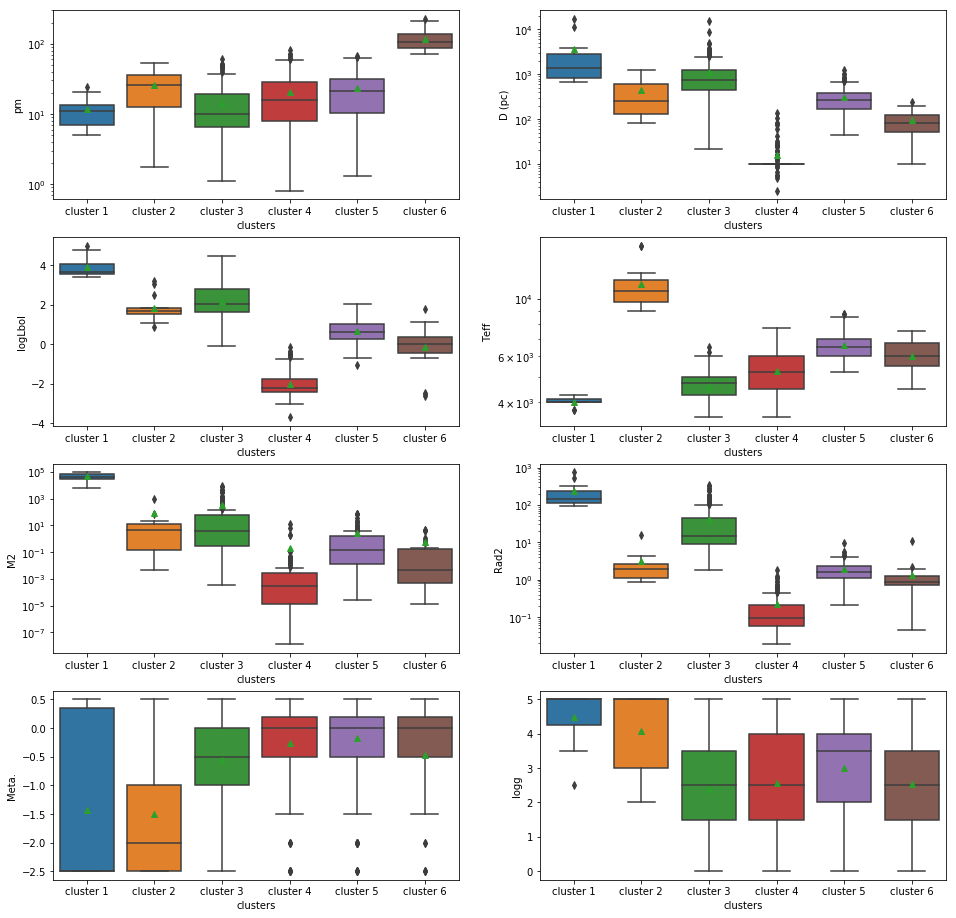

In [25]:
test_features= ["pm","D (pc)","logLbol","Teff","M2","Rad2","Meta.","logg"]
plotting_boxplots_c(all_data,test_features)

In [26]:
print(len(all_data))

6


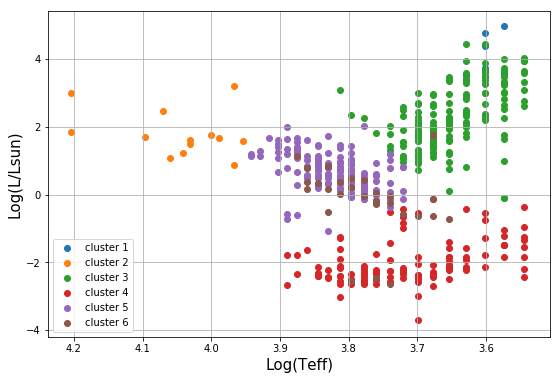

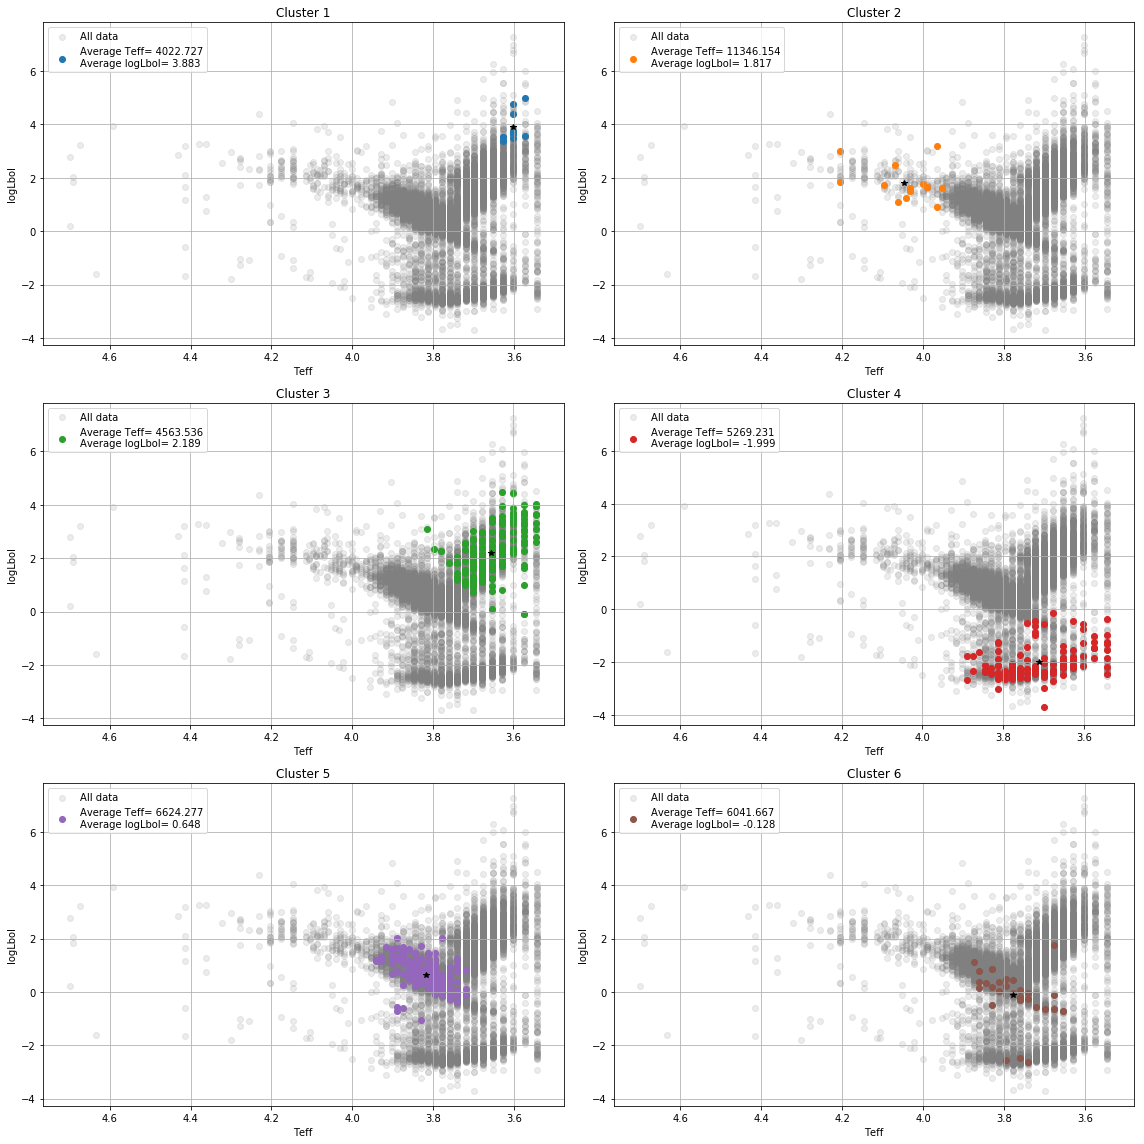

In [27]:
plot(df_hsoy,all_data,"Teff","logLbol",semilogx=True,semilogy=False,invert_x=True,plot_all_data=False,s=(9,6))
plot_compare_clusters(df_hsoy,all_data,"Teff","logLbol",semilogx=True,semilogy=False,invert_x=True)

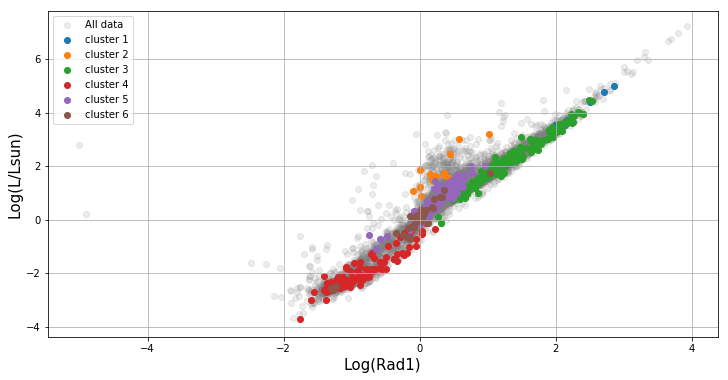

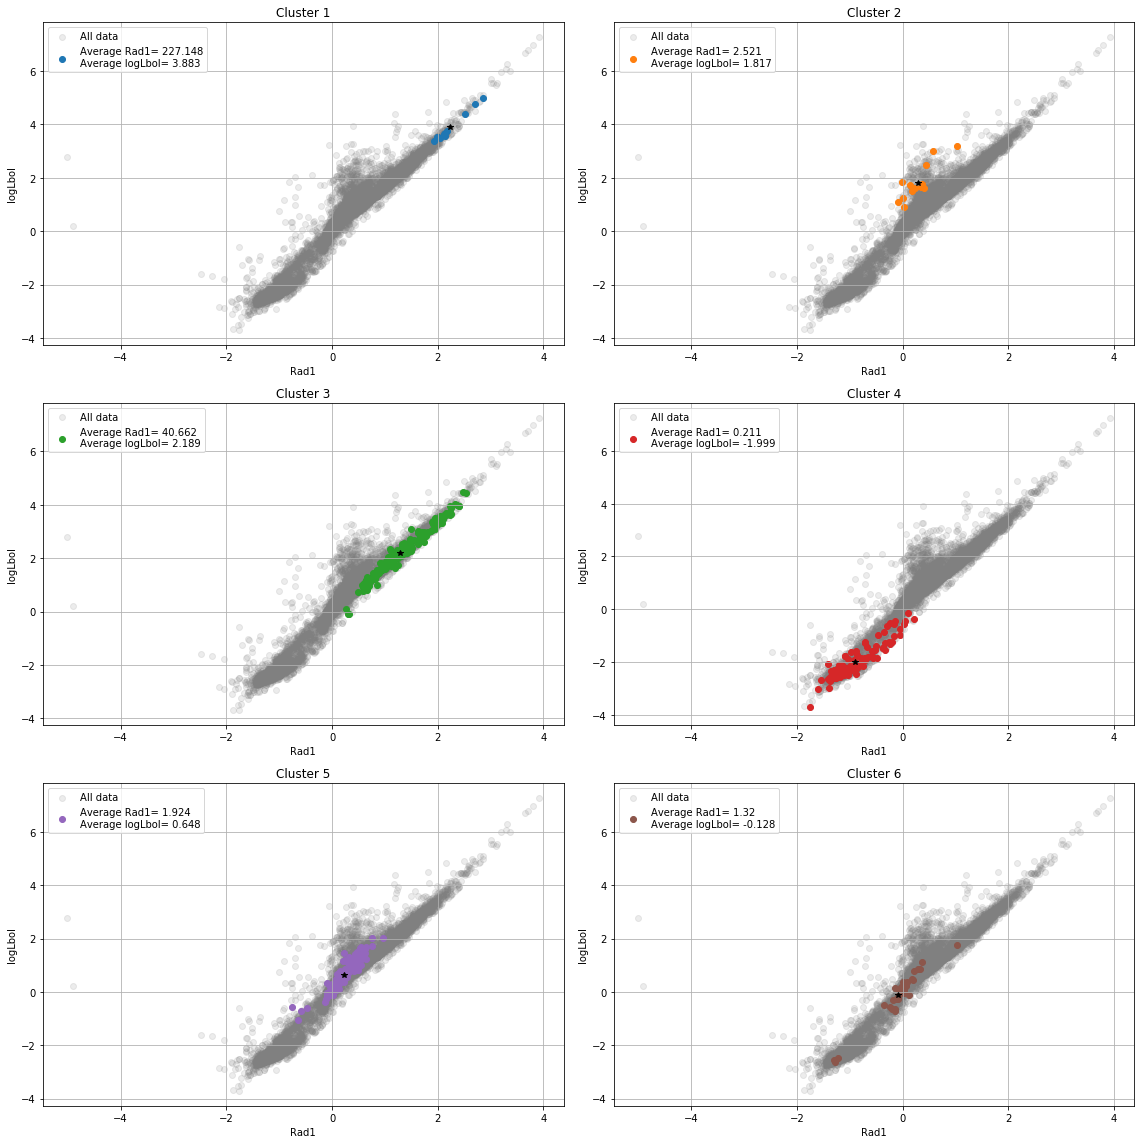

In [28]:
plot(df_hsoy,all_data,"Rad1","logLbol",semilogx=True,s=(12,6))
plot_compare_clusters(df_hsoy,all_data,"Rad1","logLbol",semilogx=True)

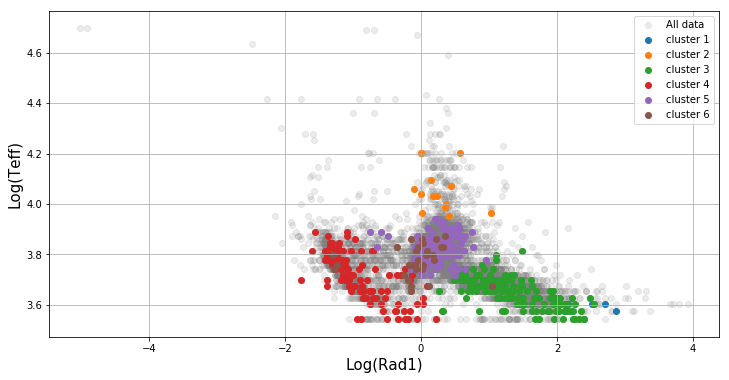

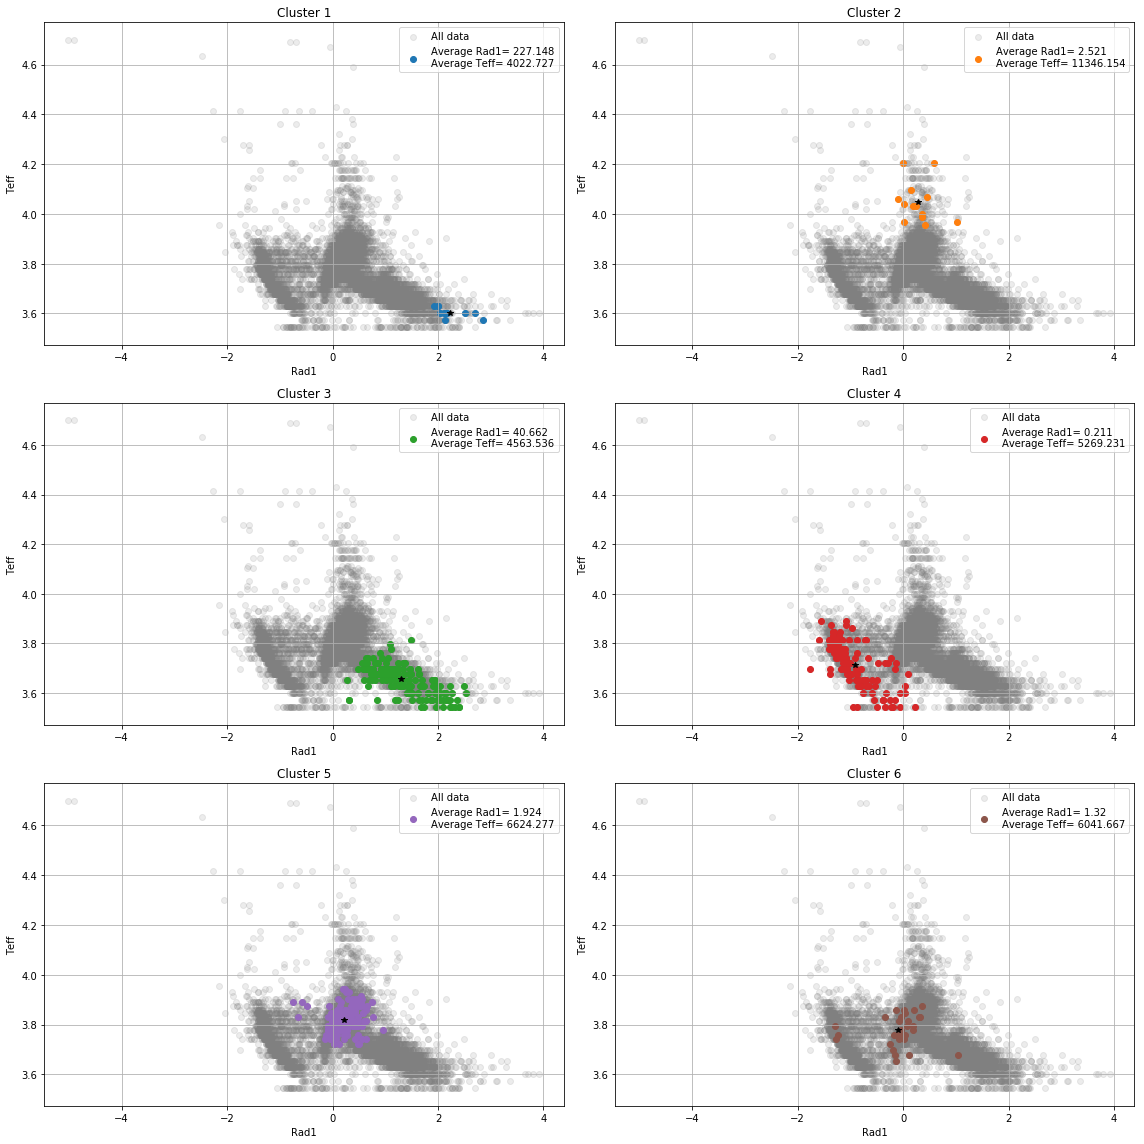

In [29]:
plot(df_hsoy,all_data,"Rad1","Teff",semilogx=True,semilogy= True,s=(12,6))
plot_compare_clusters(df_hsoy,all_data,"Rad1","Teff",semilogx=True,semilogy= True)

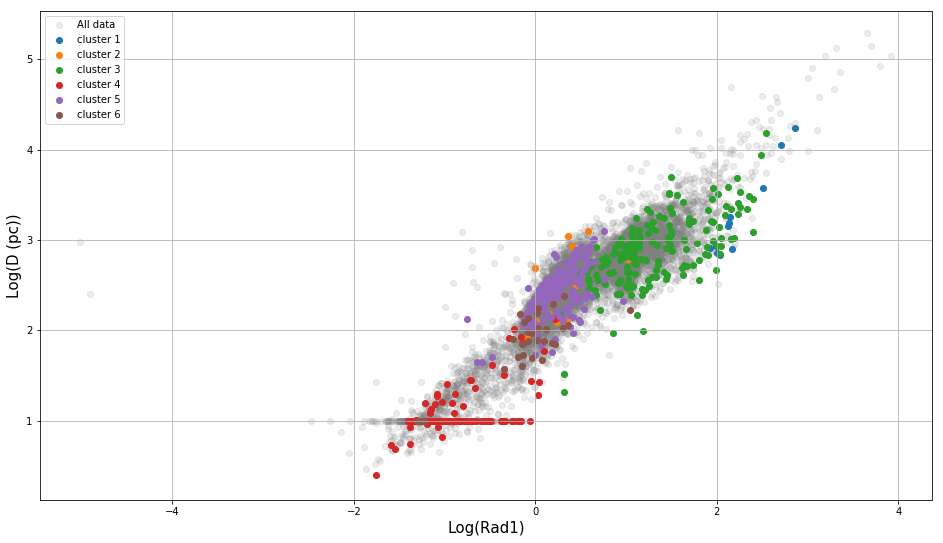

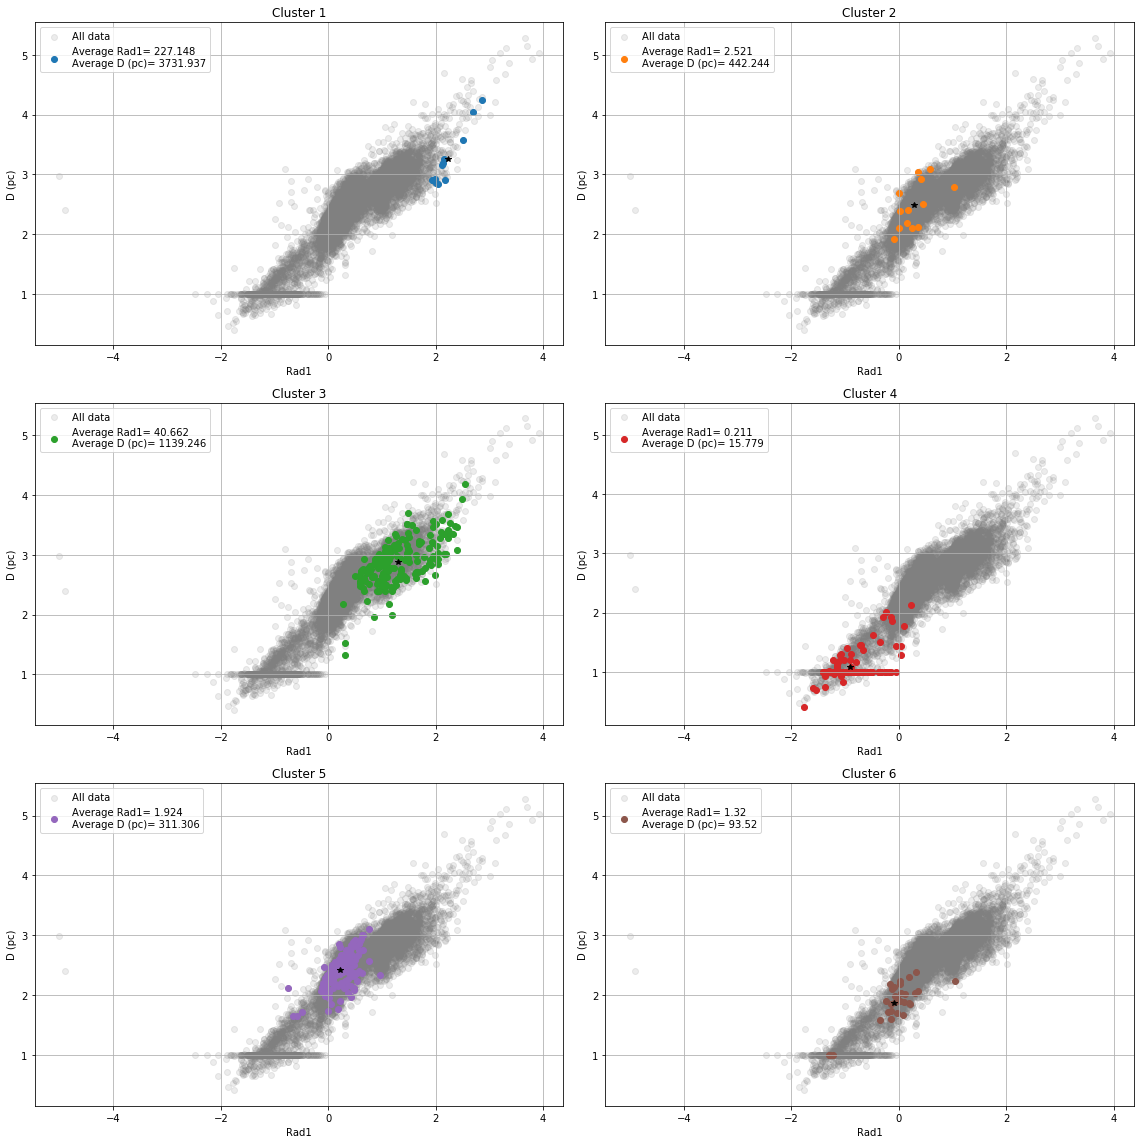

In [30]:
plot(df_hsoy,all_data,"Rad1","D (pc)",semilogx=True,semilogy= True)
plot_compare_clusters(df_hsoy,all_data,"Rad1","D (pc)",semilogx=True,semilogy= True)

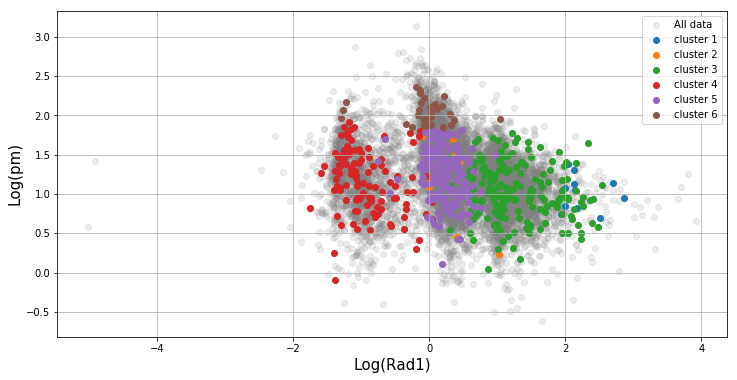

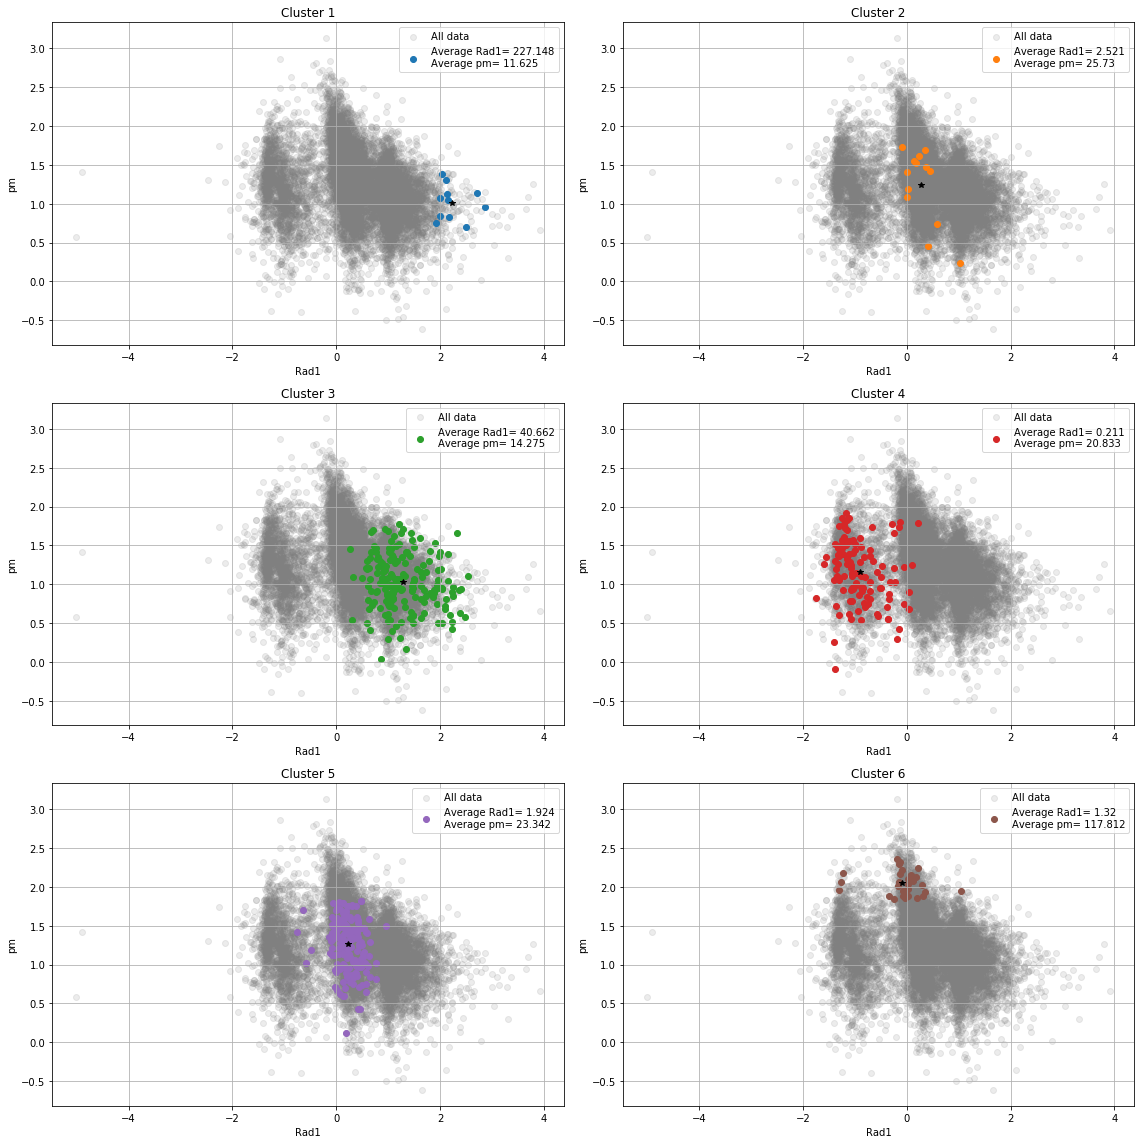

In [31]:
plot(df_hsoy,all_data,"Rad1","pm",semilogx=True,semilogy= True,s=(12,6))
plot_compare_clusters(df_hsoy,all_data,"Rad1","pm",semilogx=True,semilogy= True)

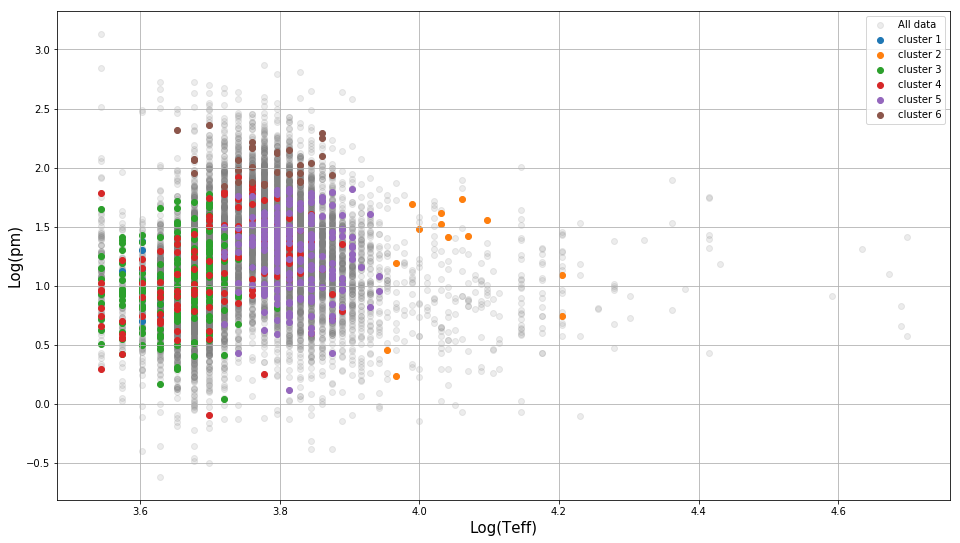

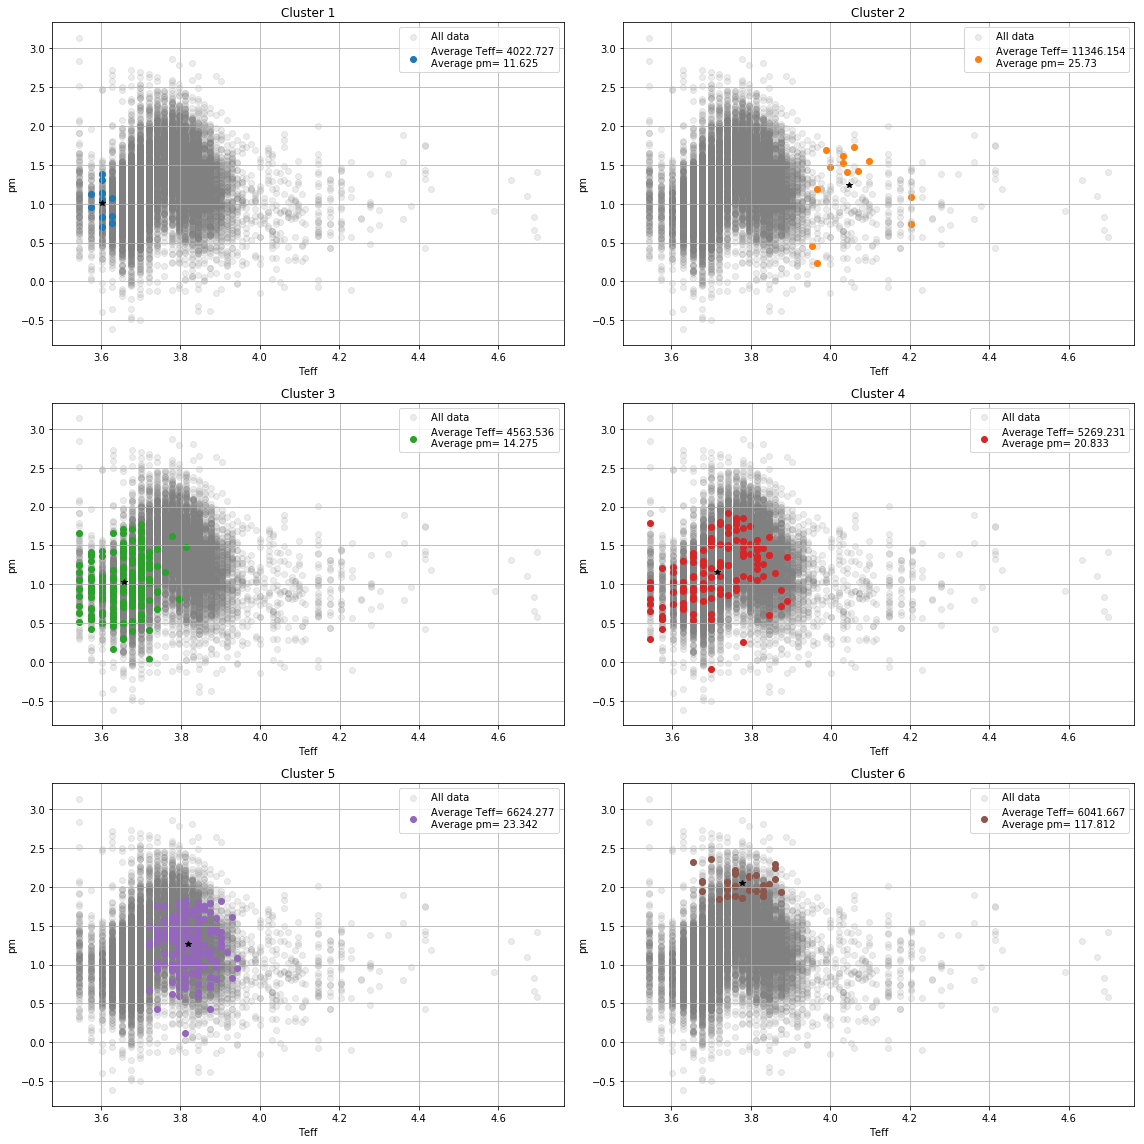

In [32]:
plot(df_hsoy,all_data,"Teff","pm",semilogx=True,semilogy= True)
plot_compare_clusters(df_hsoy,all_data,"Teff","pm",semilogx=True,semilogy= True)

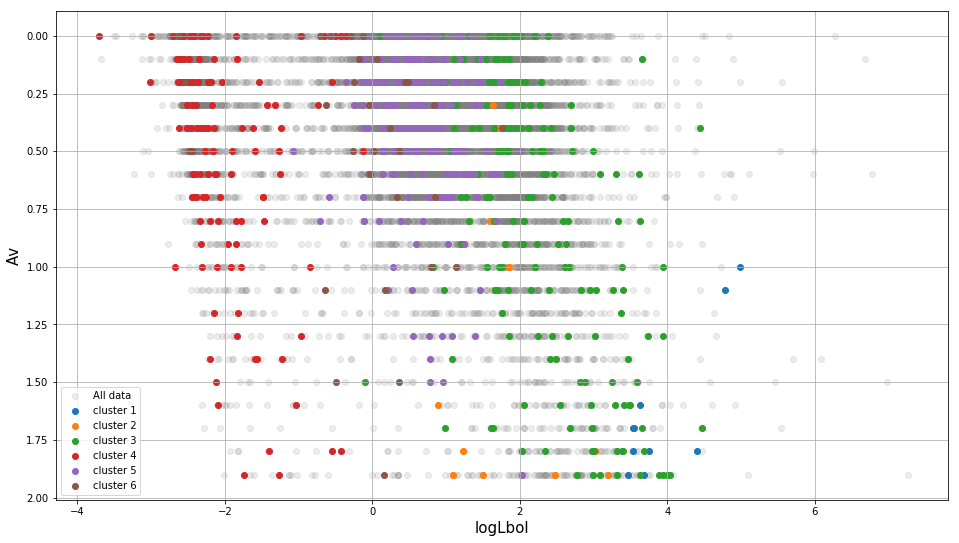

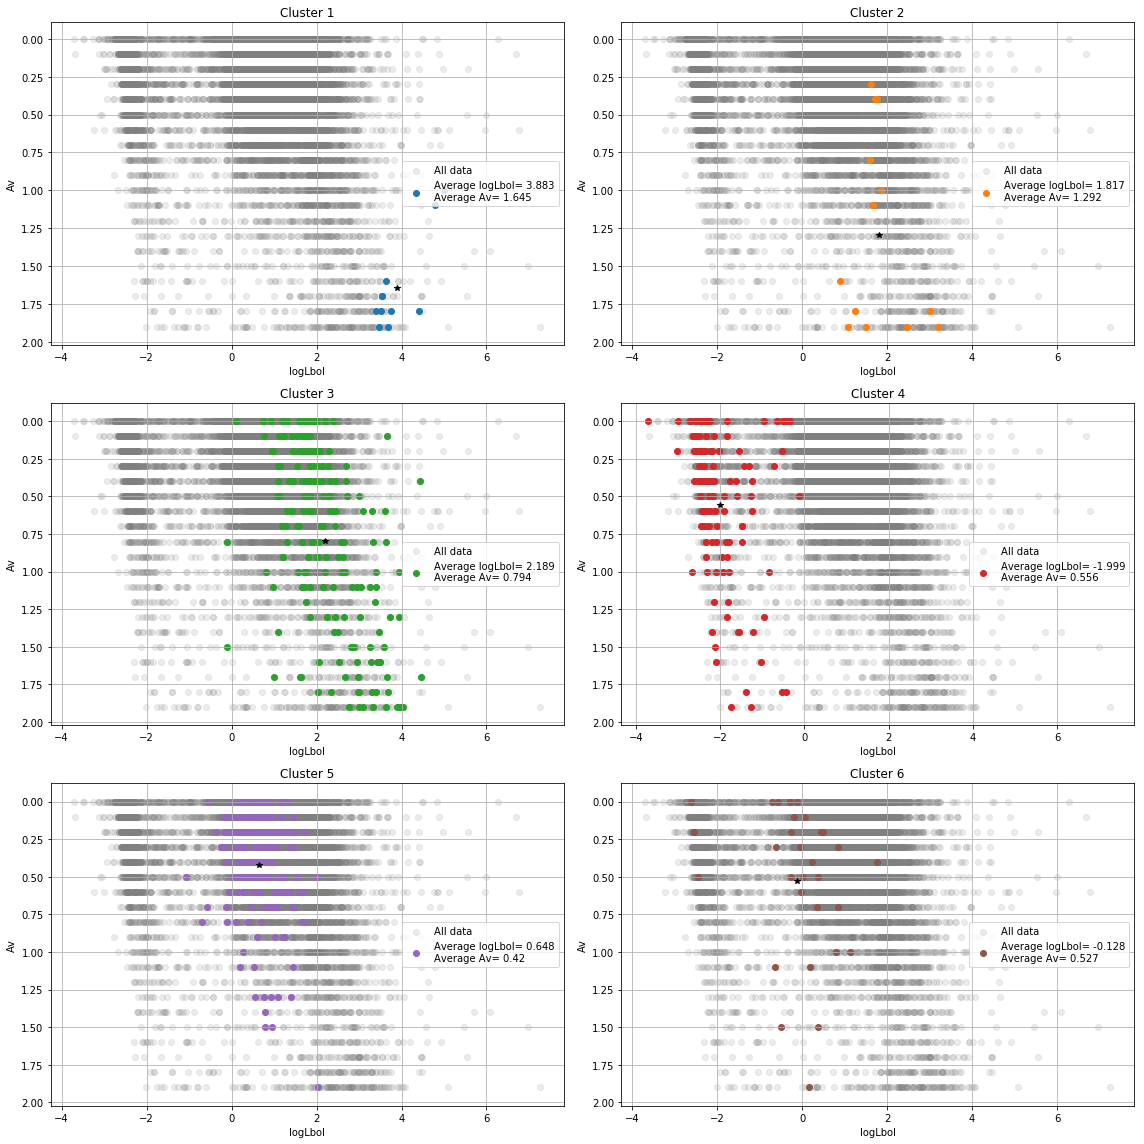

In [33]:
plot(df_hsoy,all_data,"logLbol","Av",invert_y= True)
plot_compare_clusters(df_hsoy,all_data,"logLbol","Av",invert_y= True)

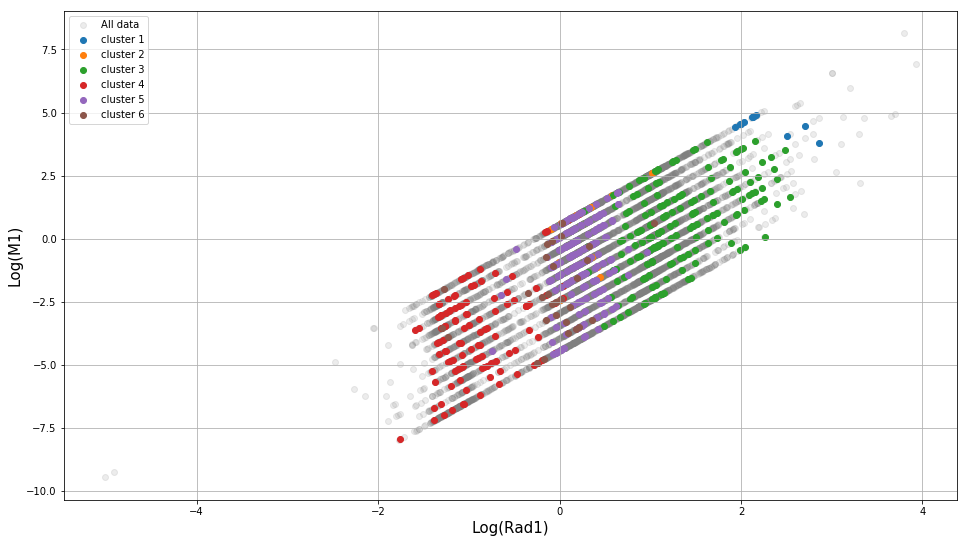

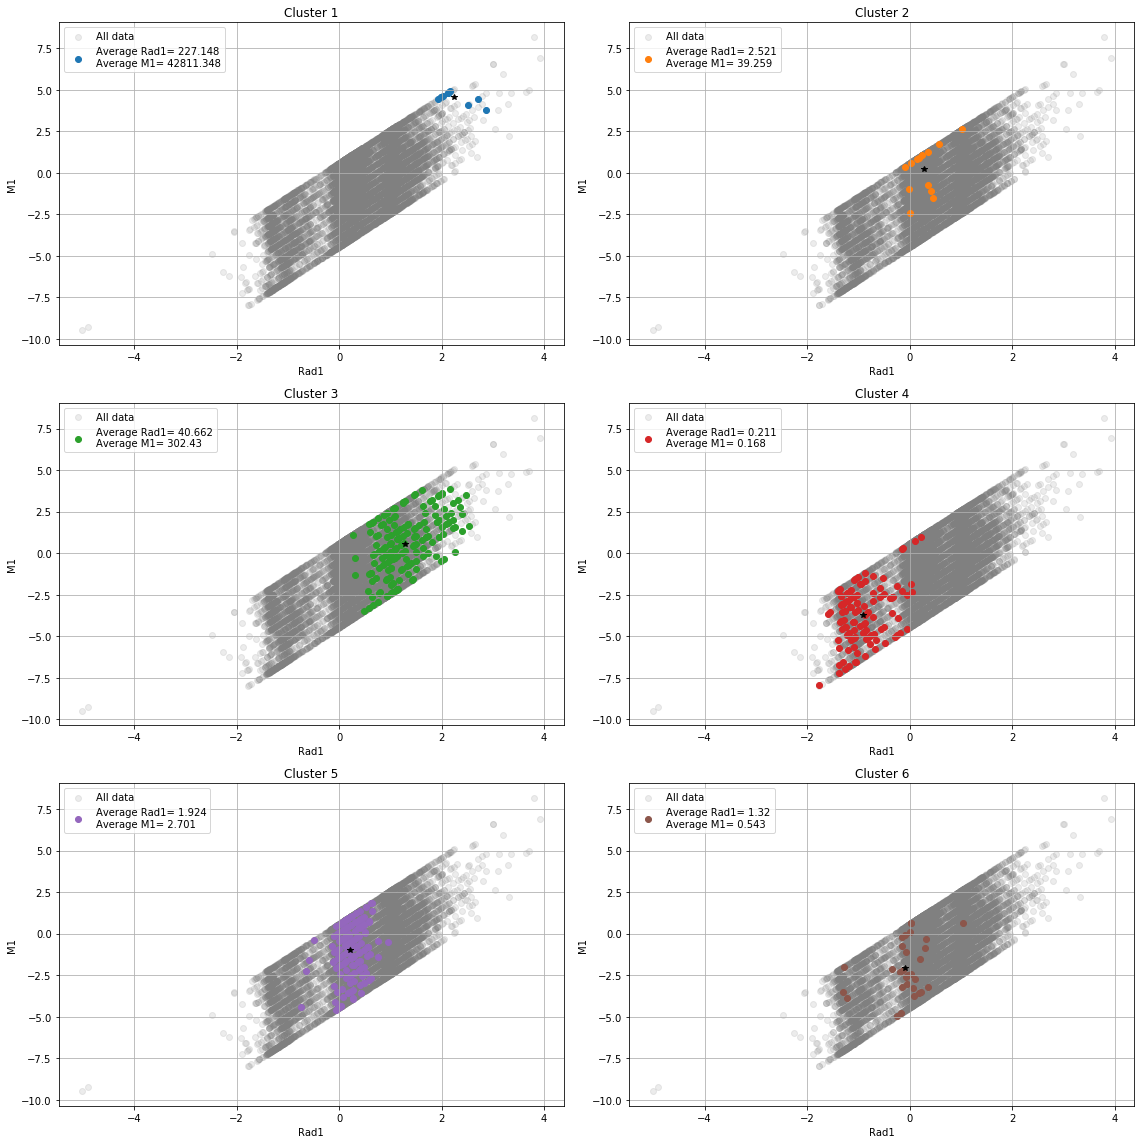

In [34]:
plot(df_hsoy,all_data,"Rad1","M1",semilogx=True,semilogy=True)
plot_compare_clusters(df_hsoy,all_data,"Rad1","M1",semilogx=True,semilogy=True)

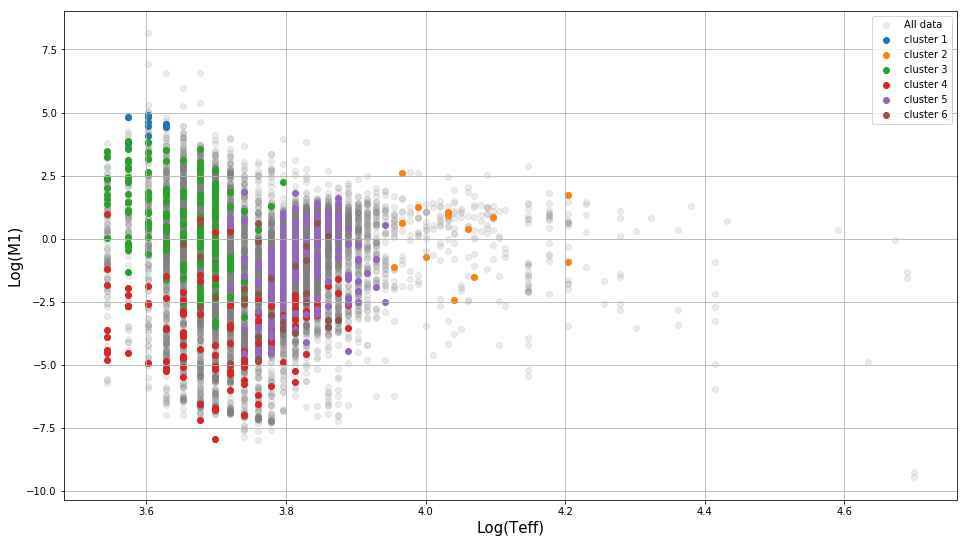

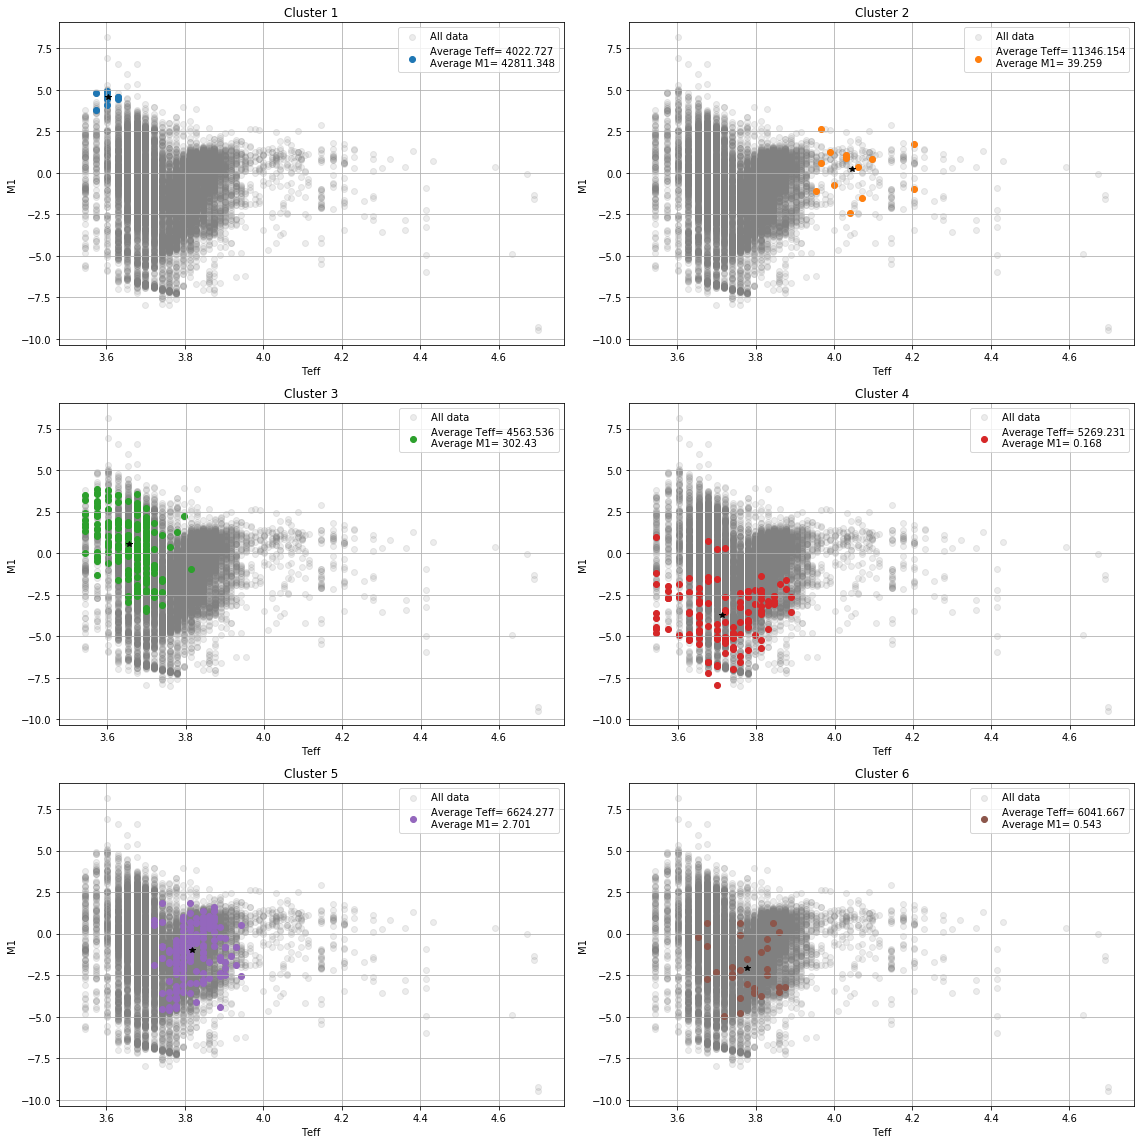

In [35]:
plot(df_hsoy,all_data,"Teff","M1",semilogx=True,semilogy=True)
plot_compare_clusters(df_hsoy,all_data,"Teff","M1",semilogx=True,semilogy=True)

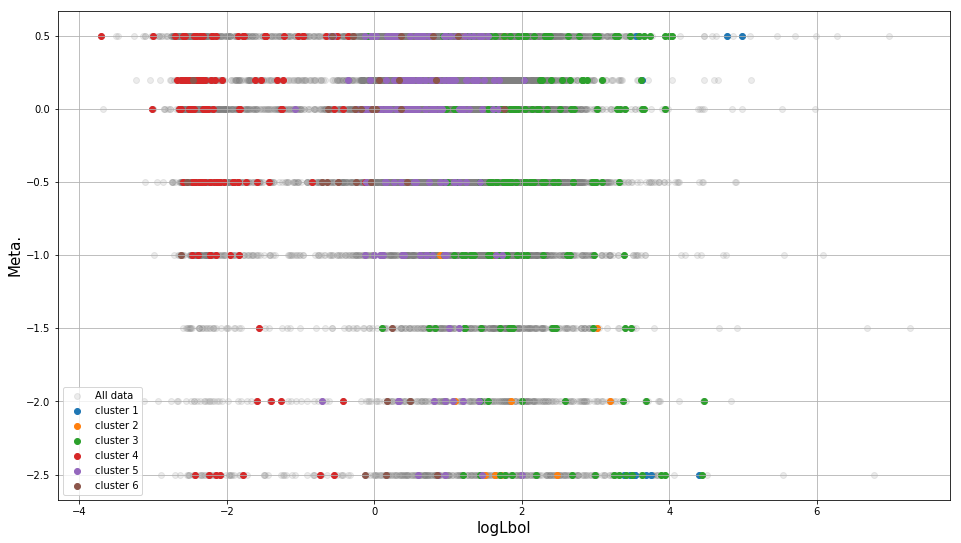

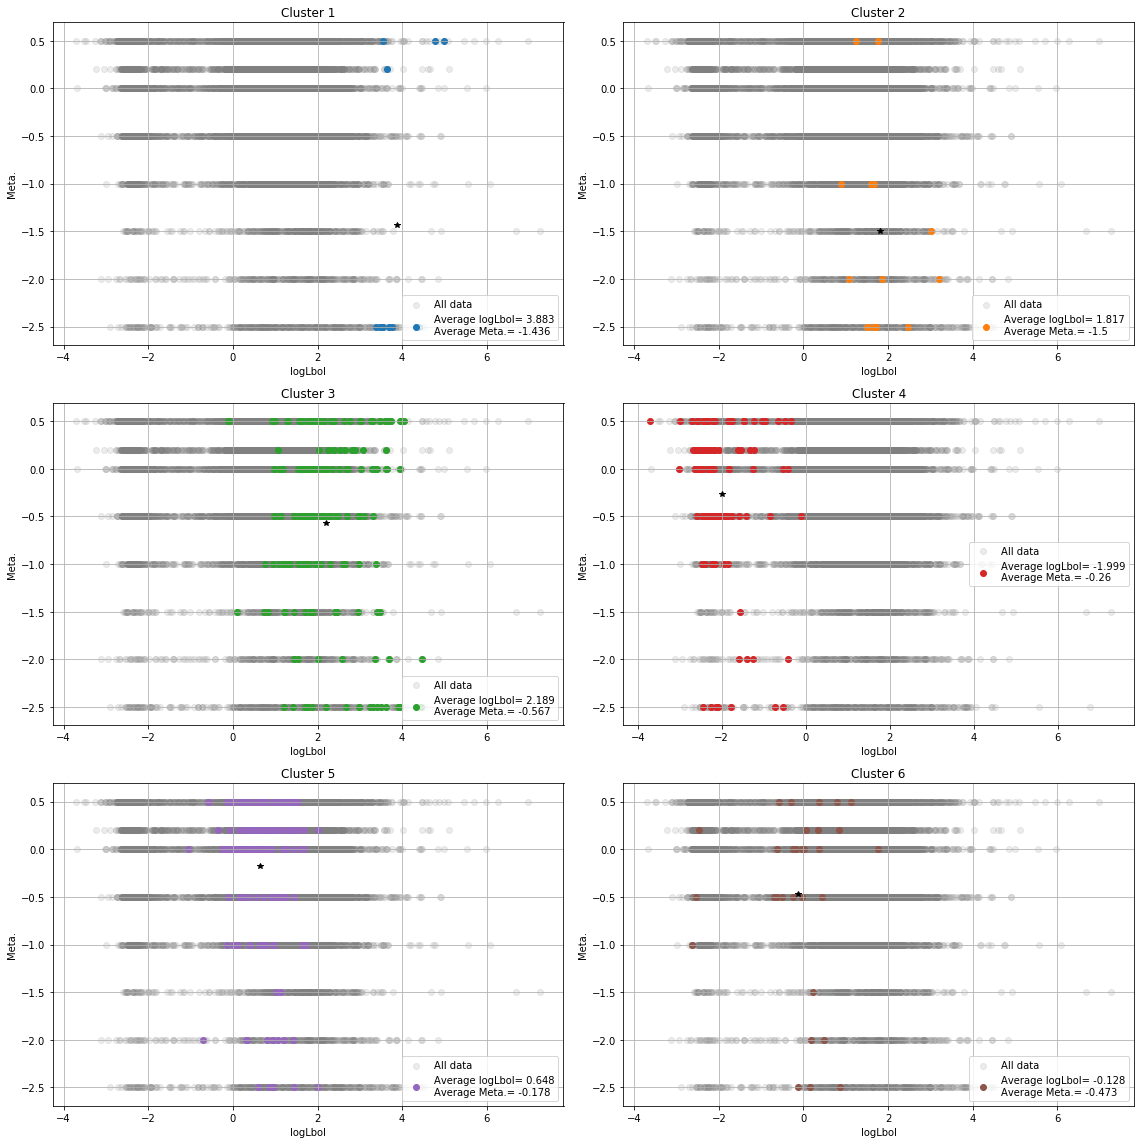

In [36]:
plot(df_hsoy,all_data,"logLbol","Meta.")
plot_compare_clusters(df_hsoy,all_data,"logLbol","Meta.")

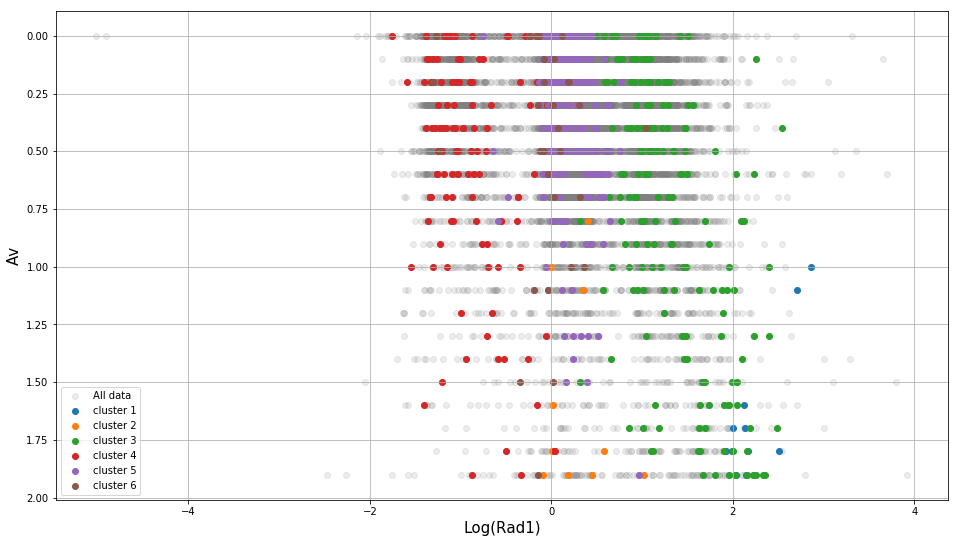

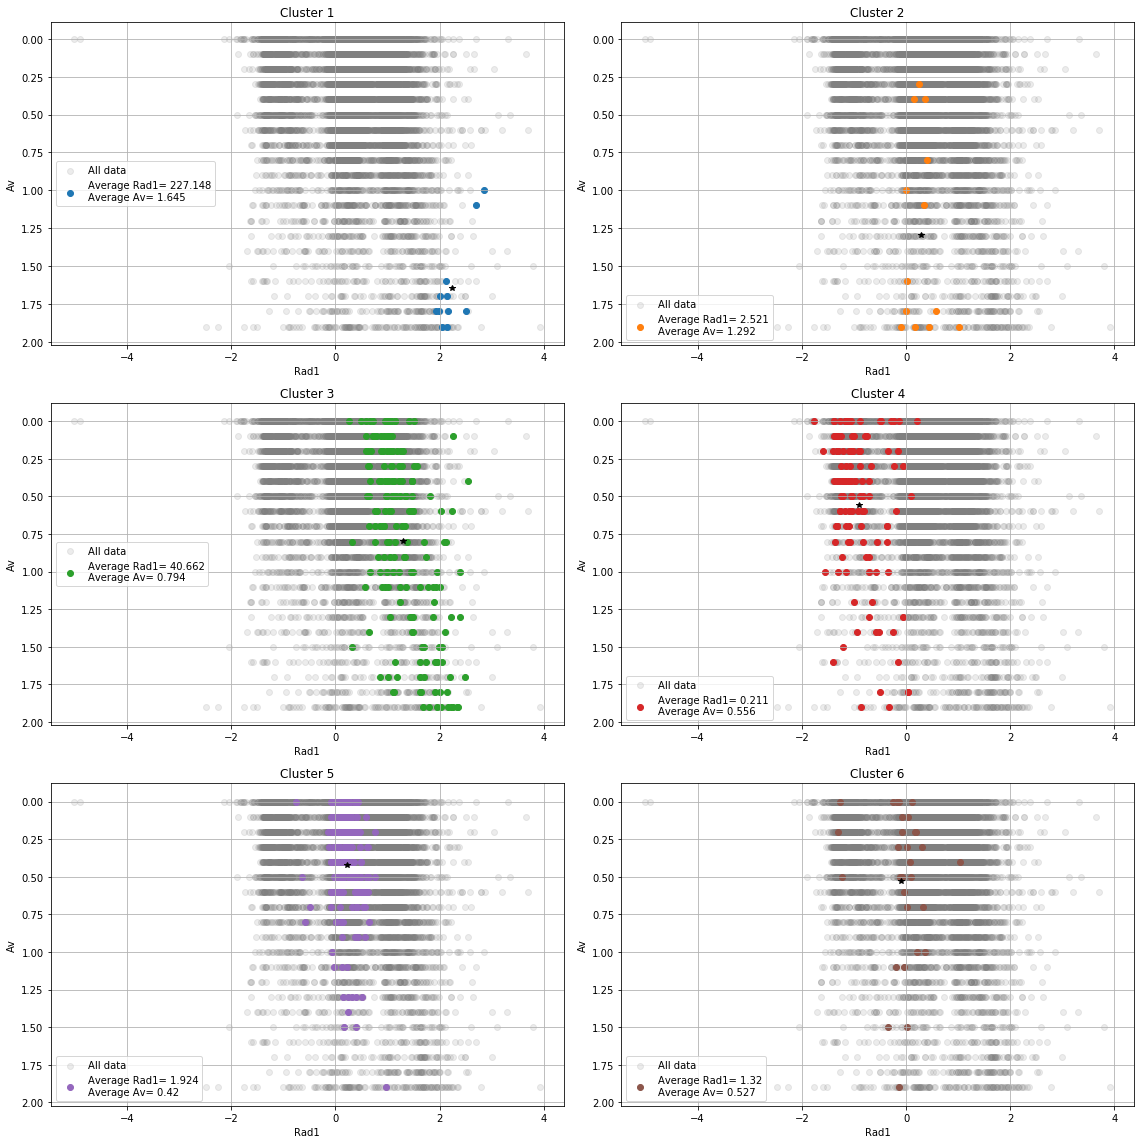

In [37]:
plot(df_hsoy,all_data,"Rad1","Av",semilogx=True,invert_y= True)
plot_compare_clusters(df_hsoy,all_data,"Rad1","Av",semilogx=True,invert_y= True)

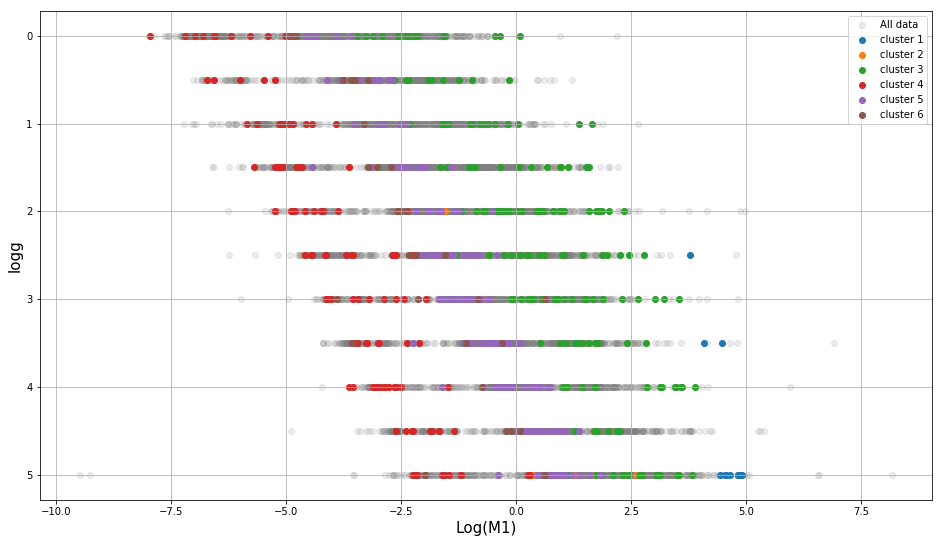

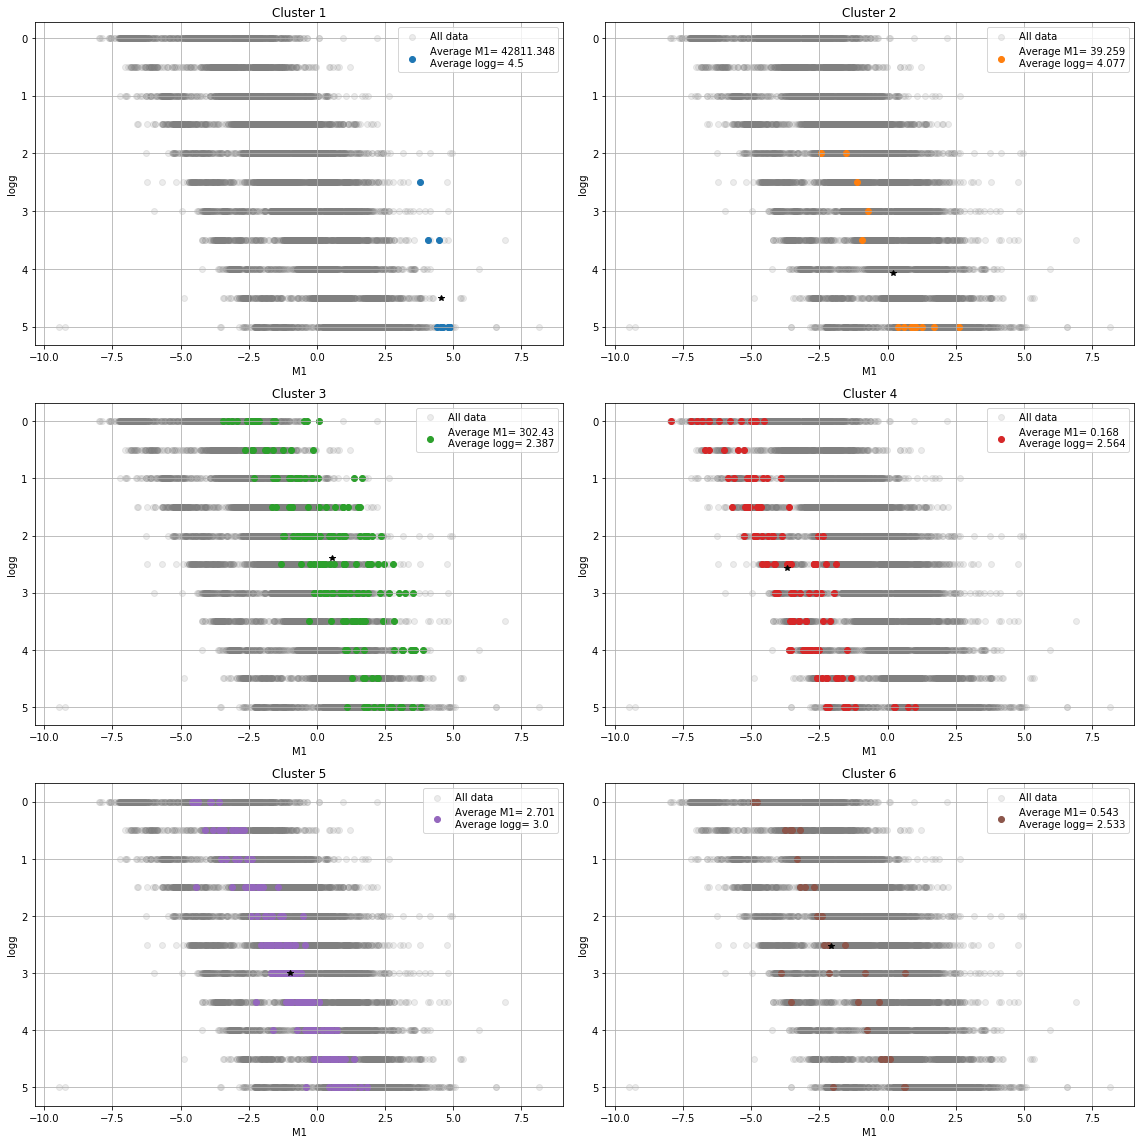

In [38]:
plot(df_hsoy,all_data,"M1","logg",semilogx=True,invert_y= True)
plot_compare_clusters(df_hsoy,all_data,"M1","logg",semilogx=True,invert_y= True)

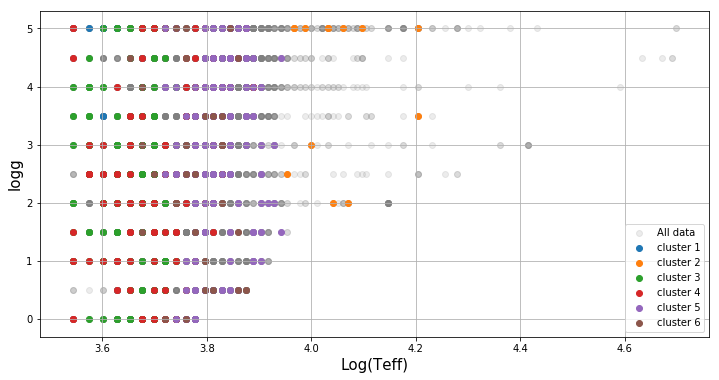

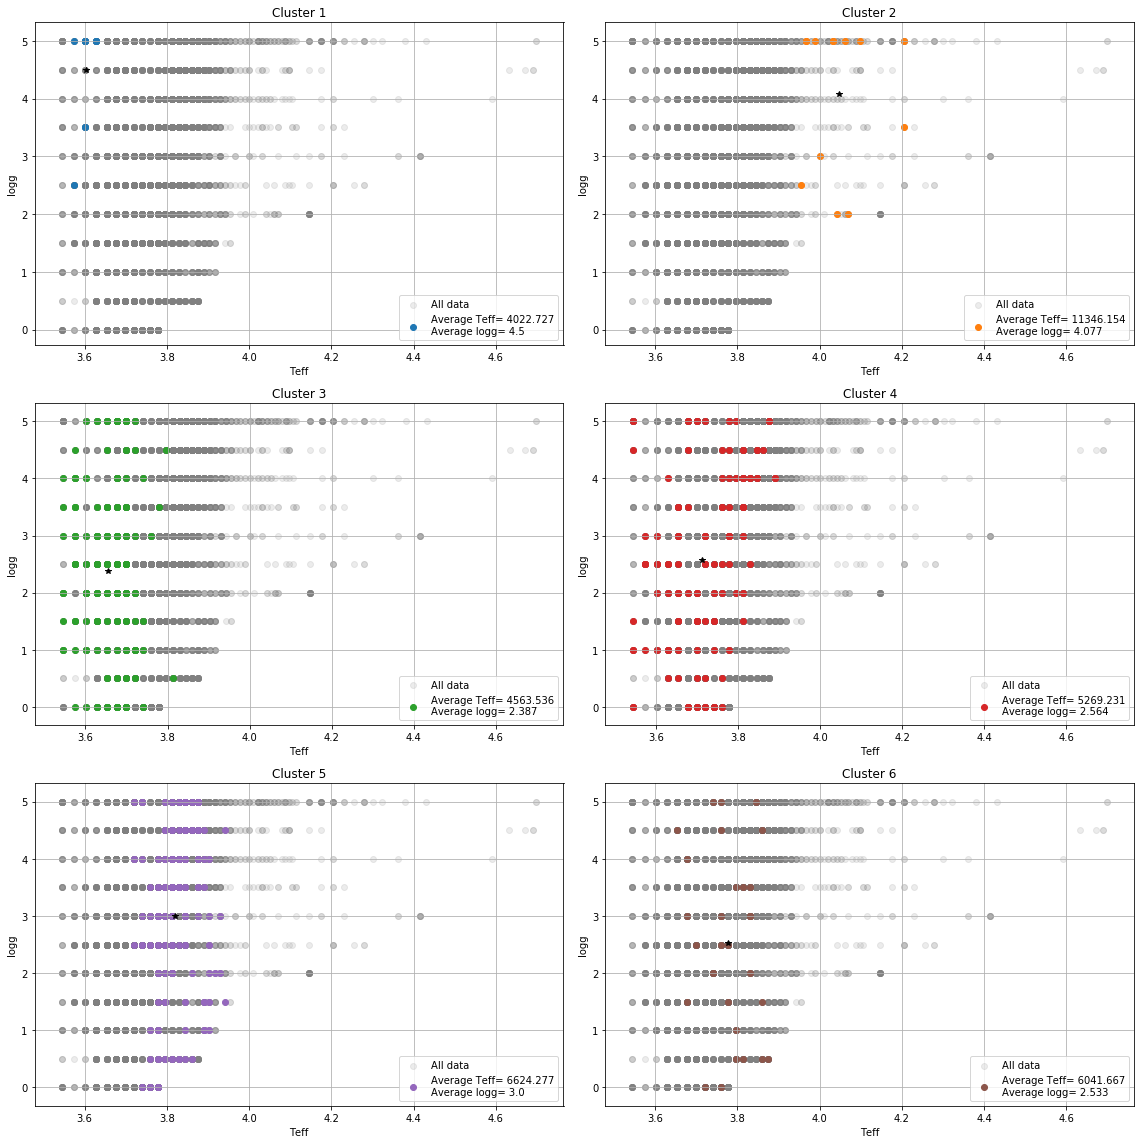

In [39]:
plot(df_hsoy,all_data,"Teff","logg",semilogx=True,s=(12,6))
plot_compare_clusters(df_hsoy,all_data,"Teff","logg",semilogx=True)

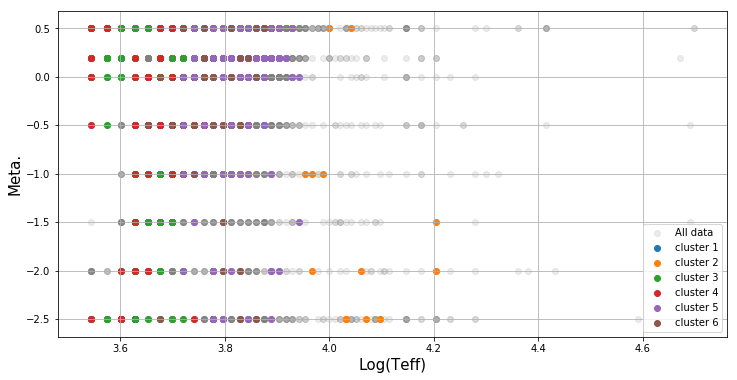

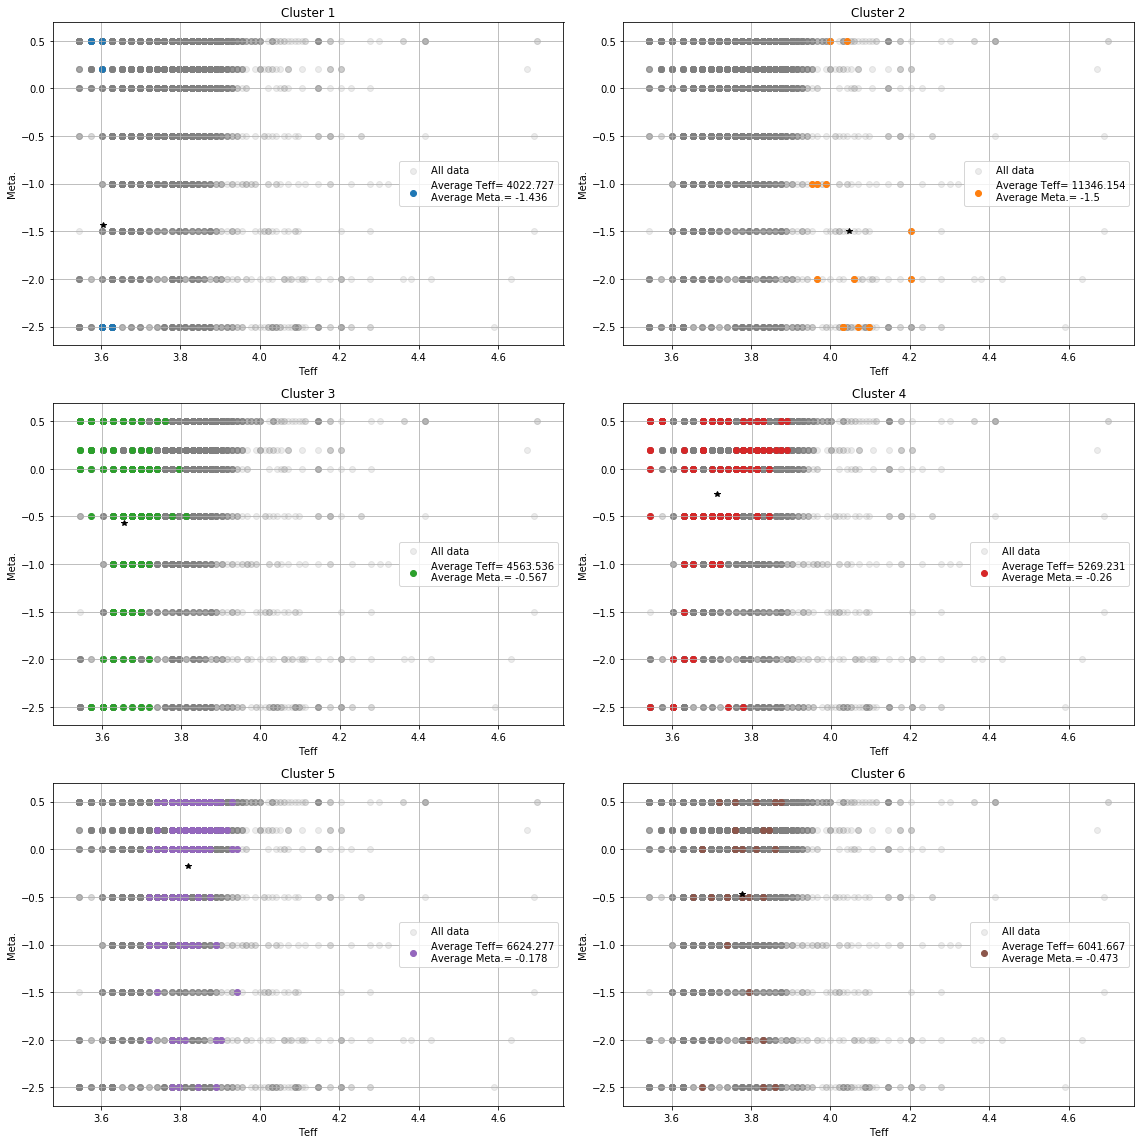

In [40]:
plot(df_hsoy,all_data,"Teff","Meta.",semilogx=True,s=(12,6))
plot_compare_clusters(df_hsoy,all_data,"Teff","Meta.",semilogx=True)